# Predicting Bike Sharing Demand in Washington DC - MBD April 2019 - Group E

In [ ]:
%pip install xgboost

In [86]:
# Importing libraries required for the project 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import datetime
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection  import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import plotly.graph_objs as go
import plotly.offline as plotly
from pprint import pprint
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn import svm

## 1. Import Data

In [87]:
# Importing the data
day = pd.read_csv("/Users/cheer/Desktop/notebooks/02_PythonDataScienceHandbook 2/Bike-Sharing-Dataset-2/day.csv", index_col="instant", parse_dates=True)
hour = pd.read_csv("/Users/cheer/Desktop/notebooks/02_PythonDataScienceHandbook 2/Bike-Sharing-Dataset-2/hour.csv", index_col="instant", parse_dates=True)

In [88]:
# Checking the head of the daily dataset
day.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [89]:
# Checking the head of the hourly dataset
hour.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [90]:
#creating duplicate columns for feature engineering
hour['hr2'] = hour['hr']
hour['season2'] = hour['season']
hour['temp2'] = hour['temp']
hour['hum2'] = hour['hum']
hour['weekday2'] = hour['weekday']

***We are going to focus on the hourly dataset as the target is to make hourly predictions. However, we will also look at the daily dataset to explore any possible differences***

## 2. Exploratory Data Analysis 
 
Different analyzes will be performed to understand the data we are dealing with. This analyzes include some of the following: 
- Checking missing values
- Checking correctness and coherence of the data 
- Checking variable types 
- Analyzing distribution of the variables 

### Check missing values

In [91]:
# Checking missing values for the day dataset
day.isnull().any()
hour.isnull().any()

dteday        False
season        False
yr            False
mnth          False
hr            False
holiday       False
weekday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
casual        False
registered    False
cnt           False
hr2           False
season2       False
temp2         False
hum2          False
weekday2      False
dtype: bool

As wen can see there are no missing values in the both csv.

In [92]:
day.shape

(731, 15)

In [93]:
hour.shape

(17379, 21)

731 days in day dataset * 24 hour. We expect that hour dataset should have 17544 entries (1 per hour). However, we only have 17379 entries.\
**What about the remaining 165 hours**

### Checking the consistency of the data 

To visualise the inconsistency in the dataset. The x axis of this graph is "date" and the y axis is "No. of hours" there is an entry for, which implies that if the value is 24 then there is a record in the dataset for the whole day(24 hours 1 entry per hour) and where ever there is a valley there is some anamoly which caused the business to be inoperable for those many hours. However, if there
was a regular pattern it could be interpretted as a routine maintenance of the bike but as there is no pattern which is witnessed implies that there is some event which occured on that day in Washington whcih caused the business to be inoperable.

Text(0.5, 1.0, 'Inconsistency of the data')

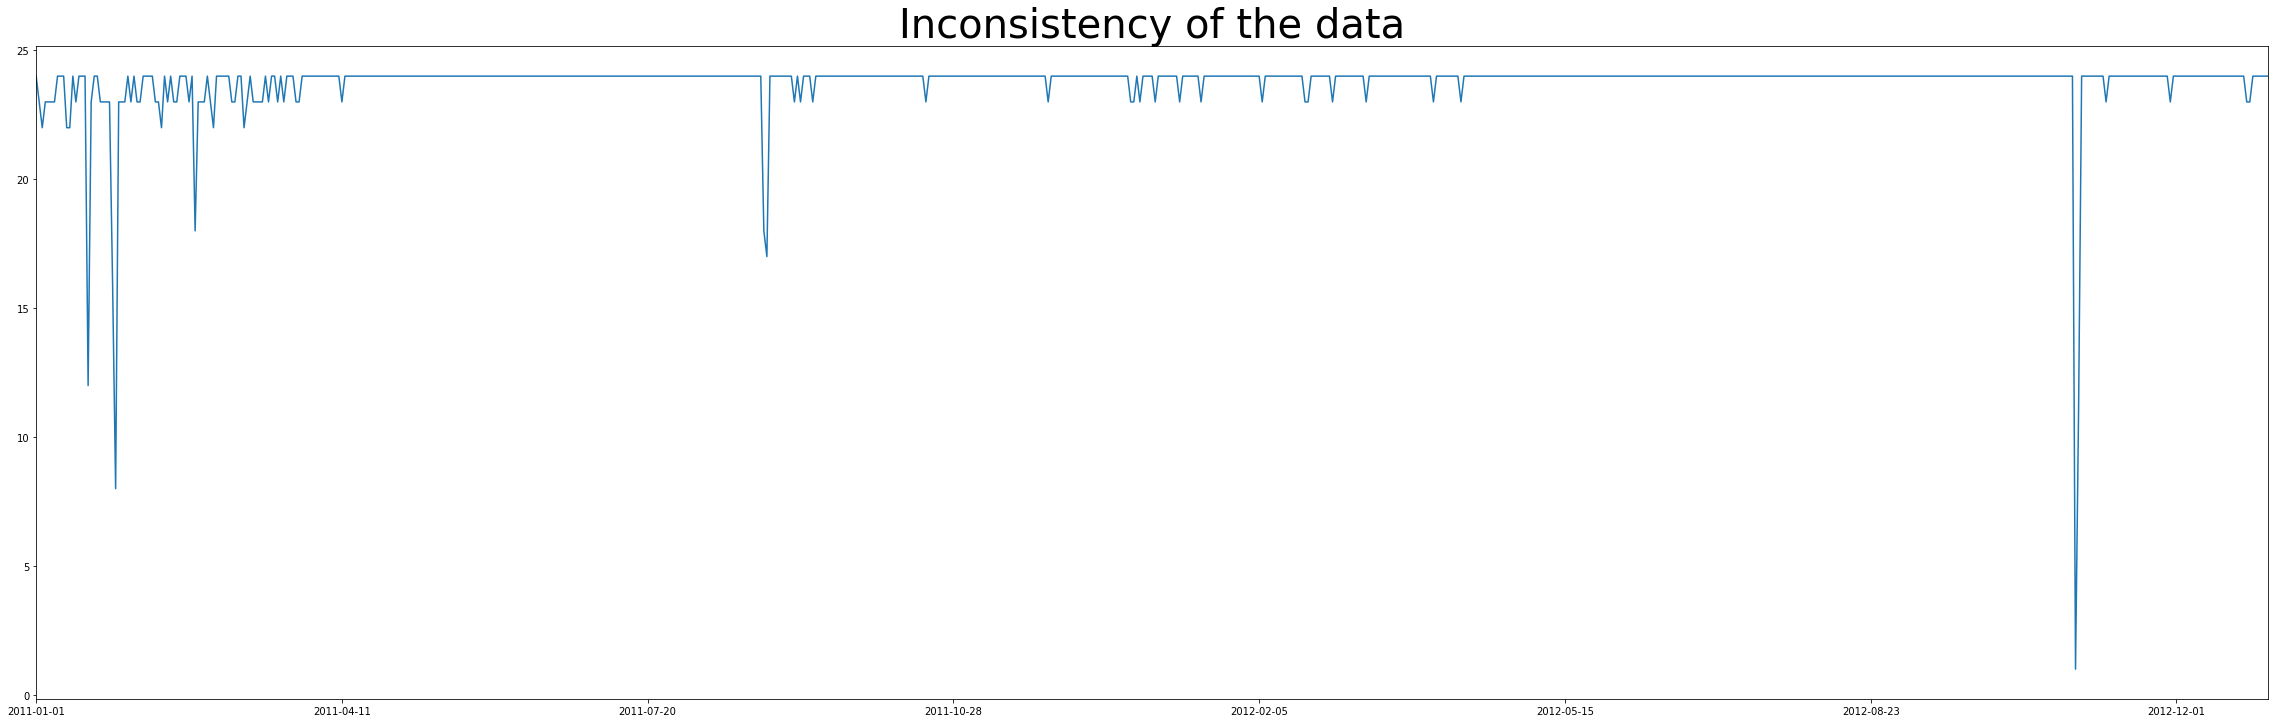

In [94]:
gf = hour.dteday.value_counts().sort_index().plot(figsize=(40,12))
gf.set_title("Inconsistency of the data",fontsize= 40)

We witness a significant dip in October 2012. There is a day when the business was not operating for 23 hours. Upon further research, we found out that Washington DC was hit by a hurricane on October 29, 2012. So it can be inferred that these missing hours are due to some underlying cause and hence cannot be imputed.

Resources: https://en.wikipedia.org/wiki/Hurricane_Sandy.

In [95]:
# Checking the different unique values make sense according to the variables of the dataset ex. yr = 2 , mnth = 12 amd hr = 24
hour.nunique() 

dteday        731
season          4
yr              2
mnth           12
hr             24
holiday         2
weekday         7
workingday      2
weathersit      4
temp           50
atemp          65
hum            89
windspeed      30
casual        322
registered    776
cnt           869
hr2            24
season2         4
temp2          50
hum2           89
weekday2        7
dtype: int64

### Convert numerical variables into categories

In [96]:
#day.info()
hour.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 1 to 17379
Data columns (total 21 columns):
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
hr2           17379 non-null int64
season2       17379 non-null int64
temp2         17379 non-null float64
hum2          17379 non-null float64
weekday2      17379 non-null int64
dtypes: float64(6), int64(14), object(1)
memory usage: 2.9+ MB


By looking at the above results we can see that some of the columns are interpreted as integers even though they are actually better interpreted as categories.

In [97]:
# Change dteday to date time
hour['dteday'] = pd.to_datetime(hour['dteday'])

# Convert the data type to eithwe category or to float
int_hour = ["season","yr","mnth","hr","holiday","weekday","workingday","weathersit"]
for col in int_hour:
    hour[col] = hour[col].astype("category")

In [98]:
# Verifiying that all the variables have been changed 
hour.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 1 to 17379
Data columns (total 21 columns):
dteday        17379 non-null datetime64[ns]
season        17379 non-null category
yr            17379 non-null category
mnth          17379 non-null category
hr            17379 non-null category
holiday       17379 non-null category
weekday       17379 non-null category
workingday    17379 non-null category
weathersit    17379 non-null category
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
hr2           17379 non-null int64
season2       17379 non-null int64
temp2         17379 non-null float64
hum2          17379 non-null float64
weekday2      17379 non-null int64
dtypes: category(8), datetime64[ns](1), float64(6), int64(6)
memory usage: 2.0 MB


***All the variables have been correctly changed***

### Visualization - Categorical Variables

In [99]:
layout = go.Layout(
    title='Total bike customers over time')

fig = go.Figure([go.Scatter(x=day['dteday'], y=day['cnt'])], layout=layout)
fig.show()

**There is a clear upwards trend going on in the bike rental business in washigton.**

Text(0, 0.5, 'Cnt')

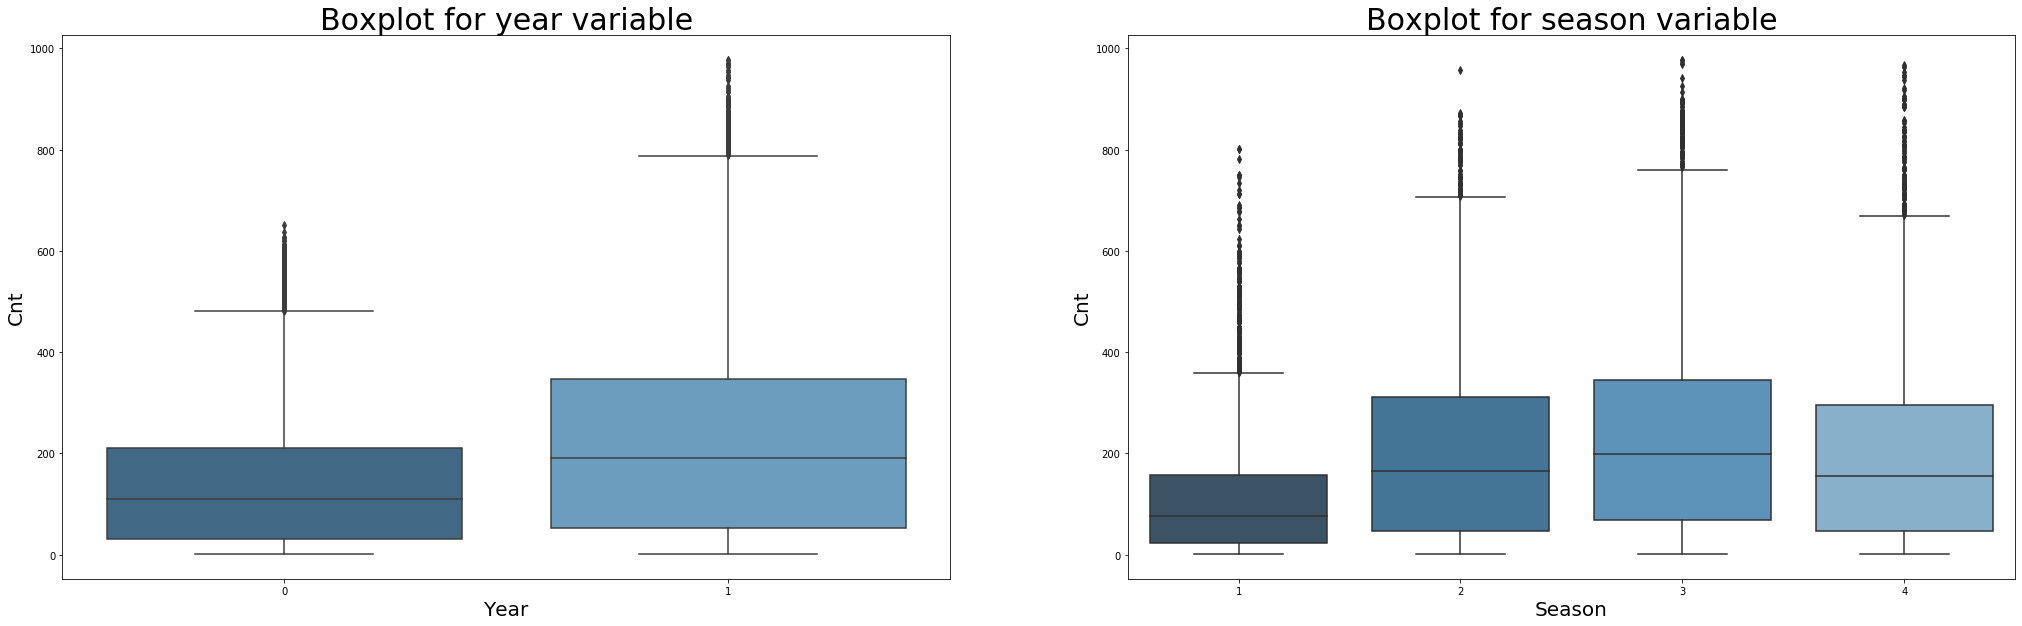

In [100]:
# Total number of passengers by year and season
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(35, 10))
sns.boxplot(x="yr", y="cnt", data=hour, ax=ax1, palette="Blues_d")
ax1.set_title("Boxplot for year variable",fontsize = 30)
ax1.set_xlabel("Year" , fontsize = 20)
ax1.set_ylabel("Cnt" , fontsize = 20)
sns.boxplot(x="season", y="cnt", data=hour, ax=ax2, palette="Blues_d")
ax2.set_title("Boxplot for season variable",fontsize = 30)
ax2.set_xlabel("Season" , fontsize = 20)
ax2.set_ylabel("Cnt" , fontsize = 20)

**Yr**: There was an increase in bike renting from year 2011 to year 2012 af around 64%. 

**Season**: People rent more bikes during season 2 (fall) and 3 (summer) and less in winter and spring. This may be due to weather condition as the weather is at its best in summer and fall in Washington.

Text(0, 0.5, 'Cnt')

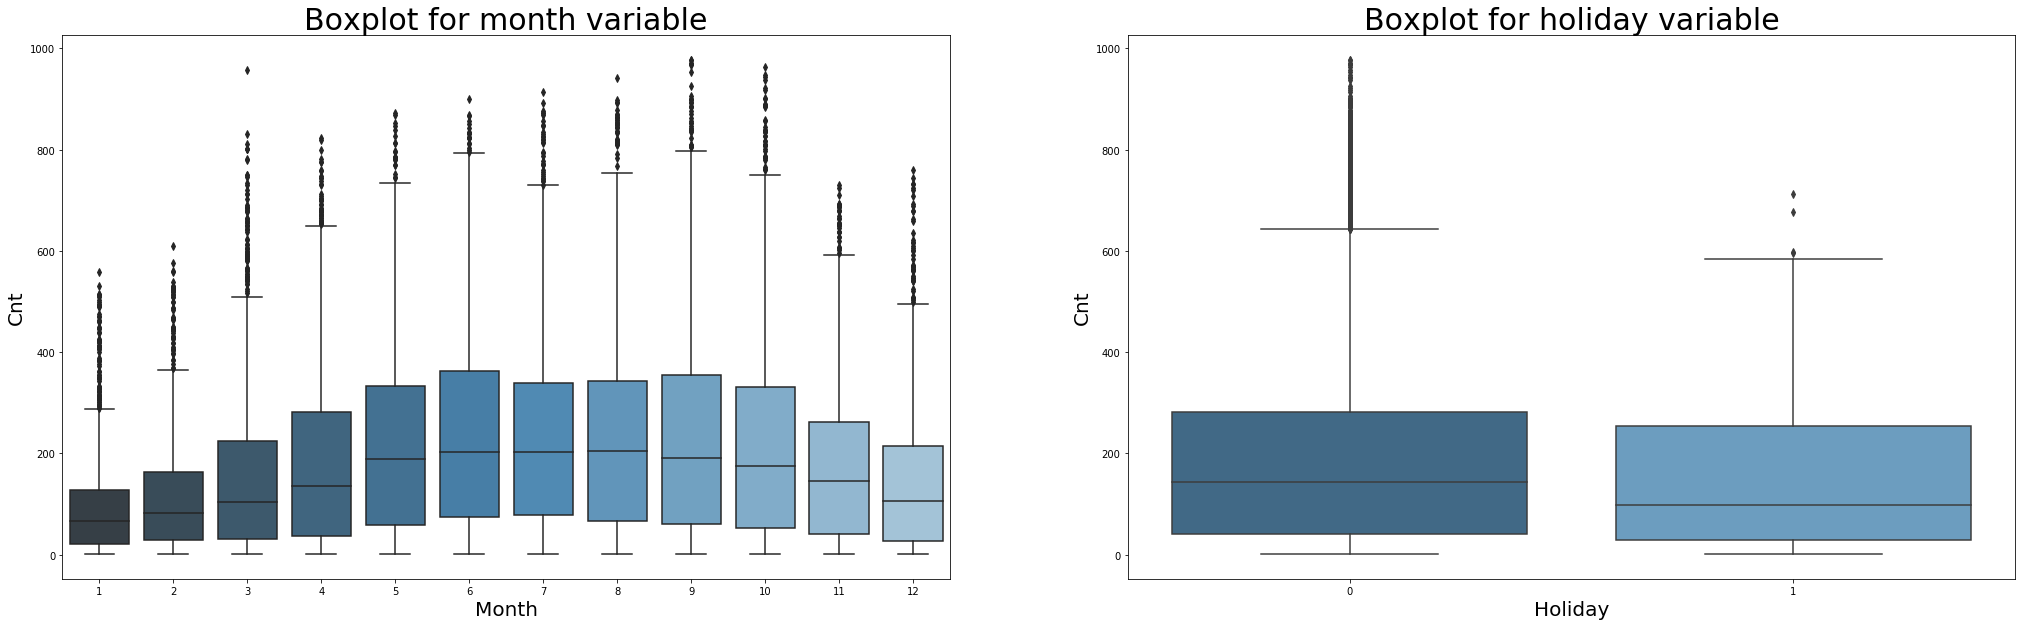

In [101]:
# Total number of passengers by month and holiday vs non holiday day
fig, (ax3, ax4) = plt.subplots(ncols=2, figsize=(35, 10))
sns.boxplot(x="mnth", y="cnt", data=hour, ax=ax3, palette="Blues_d")
ax3.set_title("Boxplot for month variable",fontsize =30)
ax3.set_xlabel("Month" , fontsize = 20)
ax3.set_ylabel("Cnt" , fontsize = 20)
sns.boxplot(x="holiday", y="cnt", data=hour, ax=ax4, palette="Blues_d")
ax4.set_title("Boxplot for holiday variable",fontsize =30)
ax4.set_xlabel("Holiday" , fontsize = 20)
ax4.set_ylabel("Cnt" , fontsize = 20)

**Month**: People rent more bikes between the months of May to October and less in during December, January and February. As the season variable, the trend is in sync with weather condition.

**Holiday**: People rent more bikes on non-holiday than holiday. This could be due to bikers who commute to work/school won't be using them during holidays.


Text(0, 0.5, 'Cnt')

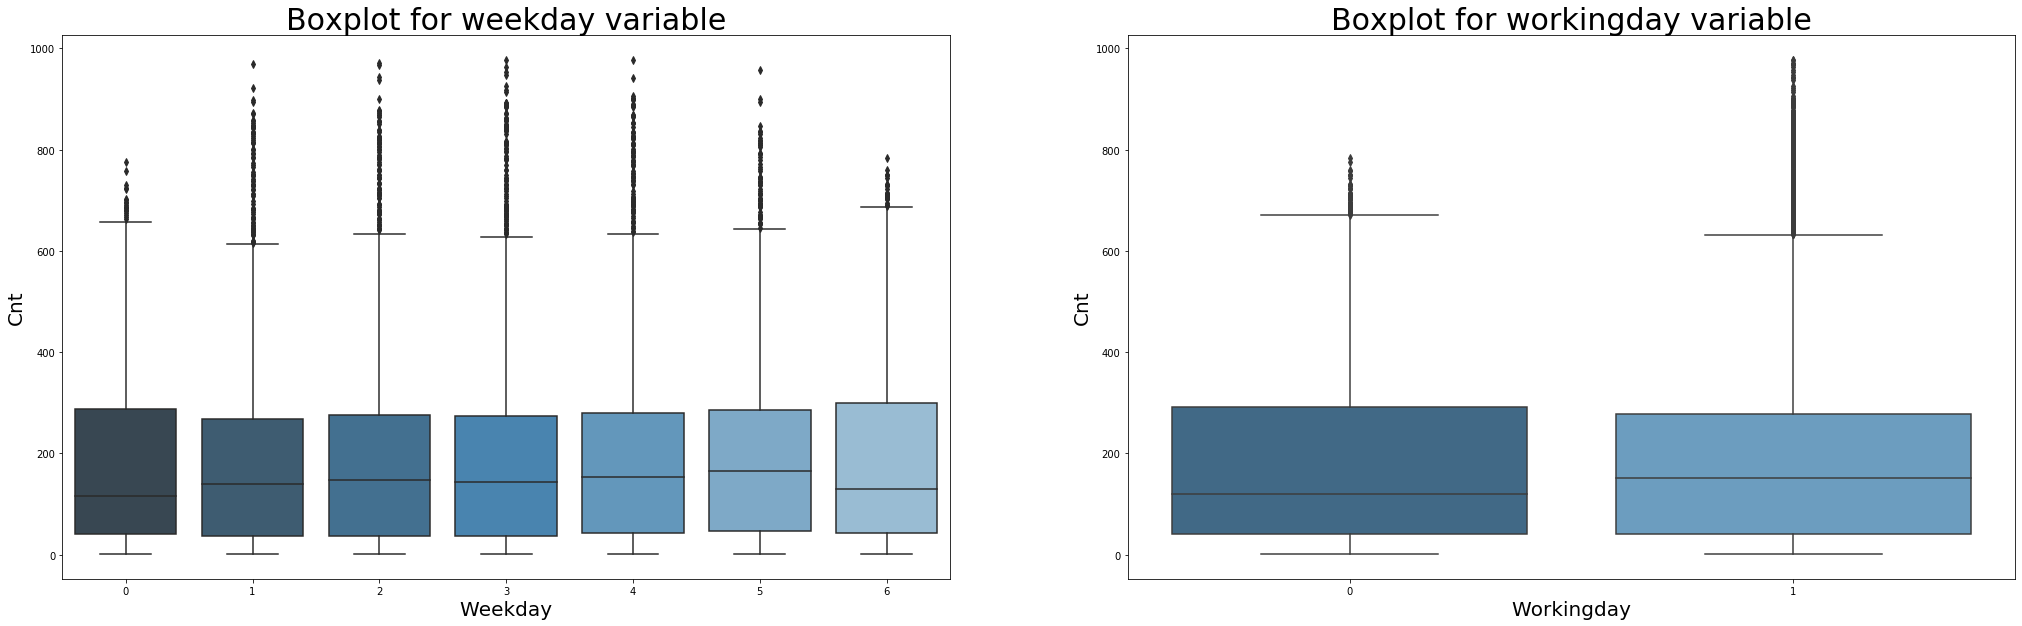

In [102]:
# Total number of passengers by weekday and by workingday vs non workingday
fig, (ax5, ax6) = plt.subplots(ncols=2, figsize=(35, 10))
sns.boxplot(x="weekday", y="cnt", data=hour, ax=ax5, palette="Blues_d")
ax5.set_title("Boxplot for weekday variable",fontsize=30)
ax5.set_xlabel("Weekday" , fontsize = 20)
ax5.set_ylabel("Cnt" , fontsize = 20)
sns.boxplot(x="workingday", y="cnt", data=hour, ax=ax6, palette="Blues_d")
ax6.set_title("Boxplot for workingday variable",fontsize= 30)
ax6.set_xlabel("Workingday" , fontsize = 20)
ax6.set_ylabel("Cnt" , fontsize = 20)

**Weekday**: People seems to rent less bikes during weekends. Again this could be due to the bikers who commute to go to work/school. Monday has also less count than the rest of weekdays.


**Workingday**: There seem to be no big difference between the total amount of people renting bikes on the weekend or during the week. The median is higher for workingdays than for non-working days, meaning people mostly use bikes to commute within the city. 


Text(0, 0.5, 'Cnt')

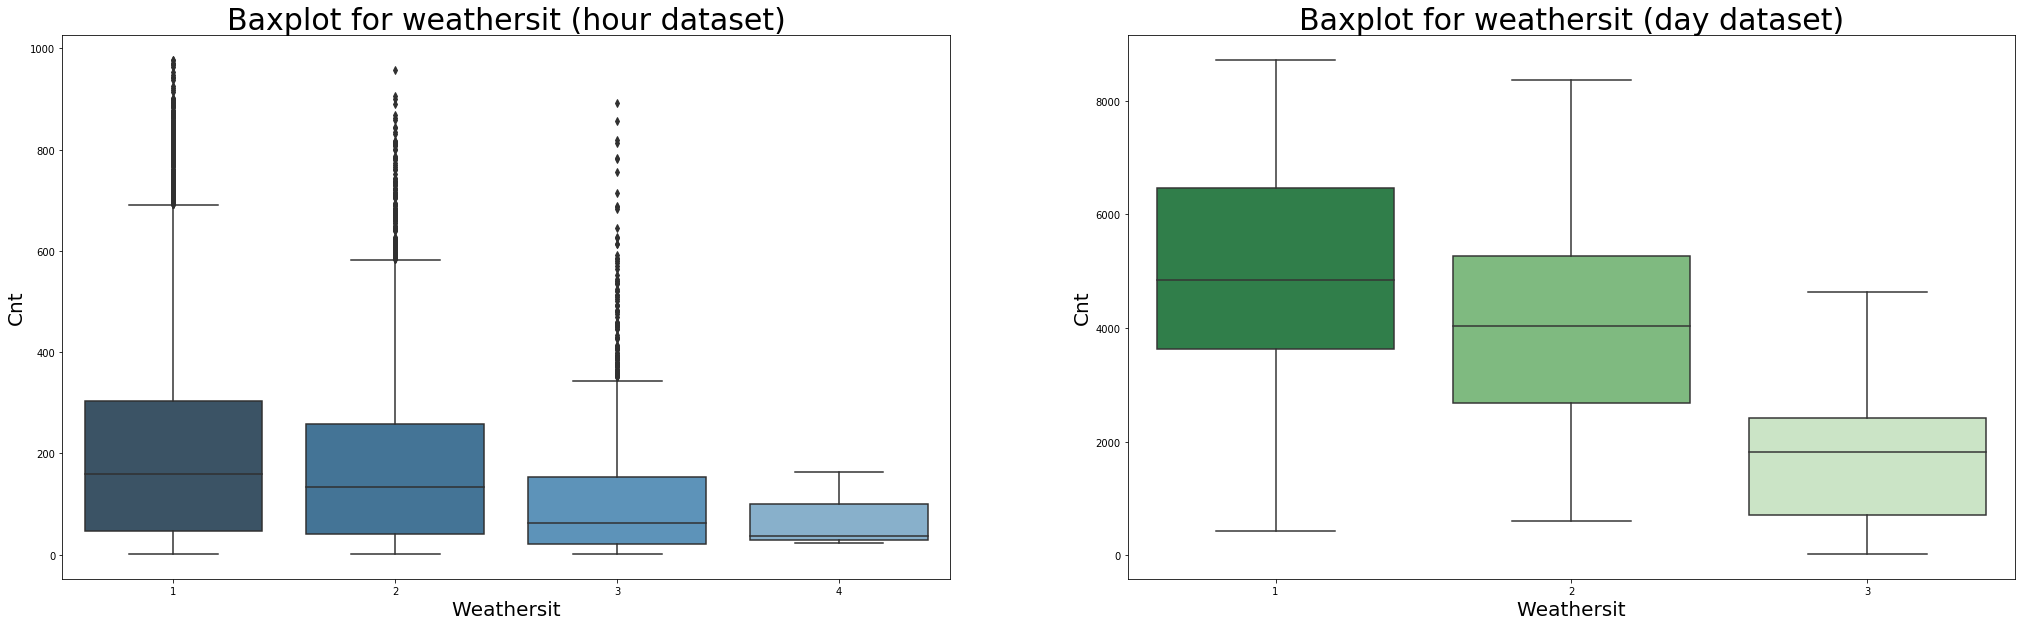

In [103]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(35,10))
sns.boxplot(x="weathersit", y="cnt", data=hour, ax=ax1, palette="Blues_d")
ax1.set_title("Baxplot for weathersit (hour dataset)", fontsize = 30)
ax1.set_xlabel("Weathersit" , fontsize = 20)
ax1.set_ylabel("Cnt" , fontsize = 20)
sns.boxplot(x="weathersit", y="cnt", data=day, ax=ax2, palette="Greens_r")
ax2.set_title("Baxplot for weathersit (day dataset)", fontsize = 30)
ax2.set_xlabel("Weathersit" , fontsize = 20)
ax2.set_ylabel("Cnt" , fontsize = 20)
# absence of the 4th category in the day dataset implies that there was no day in which the weather conditions were 
# == "Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog" for the whole day (which logically makes sense)

Text(0, 0.5, 'Cnt')

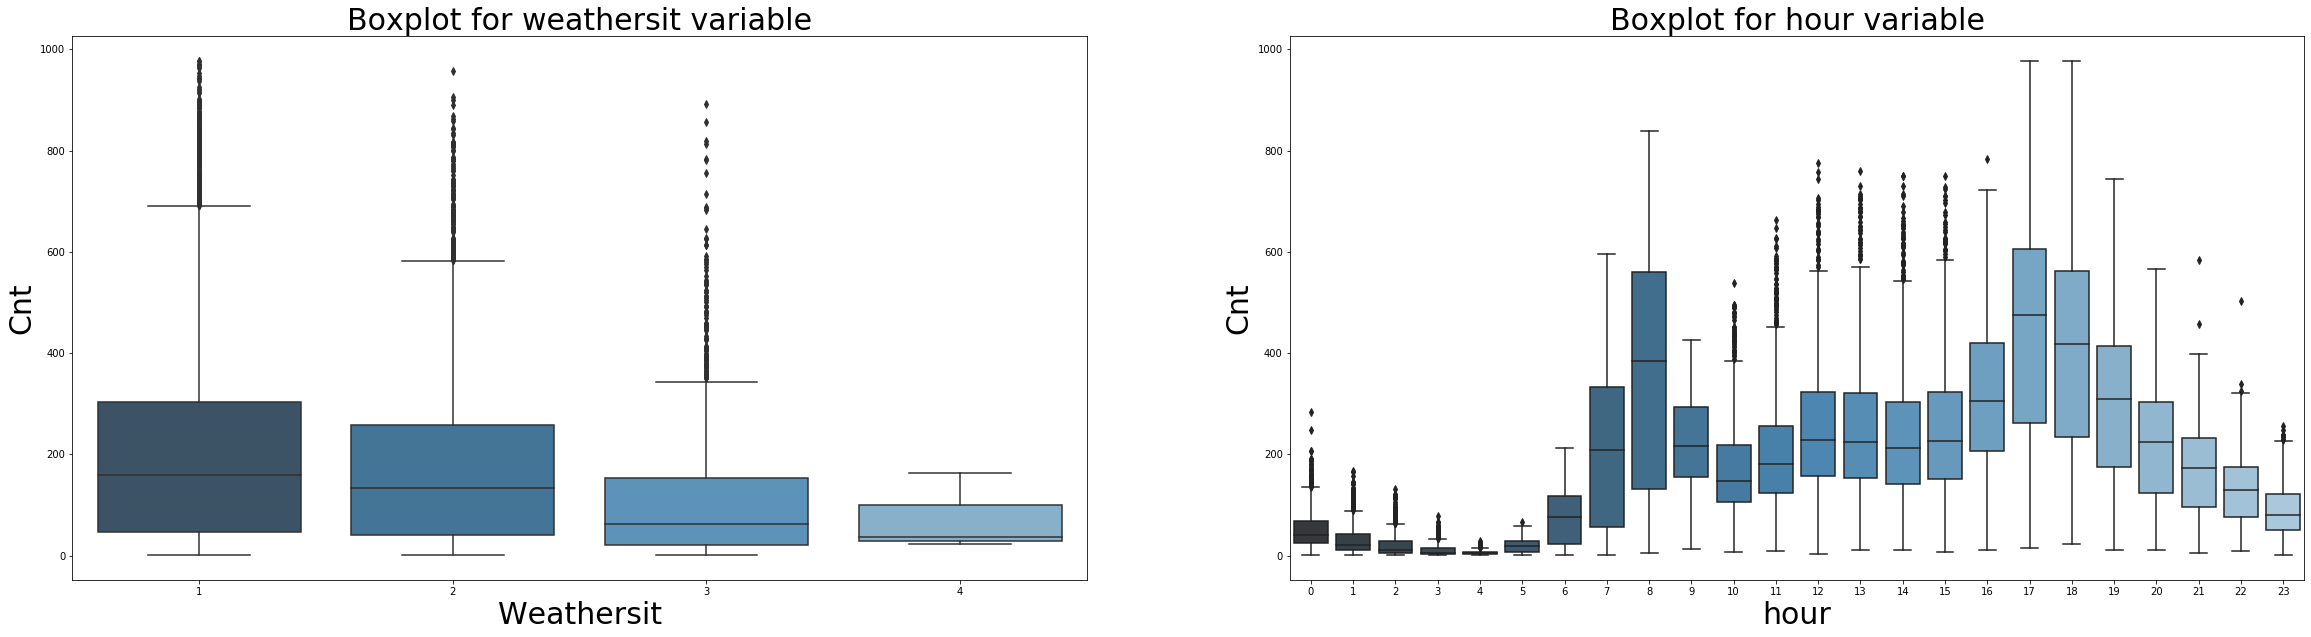

In [104]:
# Total number of passengers by weather situation and hour 
fig, (ax7, ax8) = plt.subplots(ncols=2, figsize=(40, 10))
sns.boxplot(x="weathersit", y="cnt", data=hour, ax = ax7, palette="Blues_d")
ax7.set_title("Boxplot for weathersit variable",fontsize=30)
ax7.set_xlabel("Weathersit" , fontsize = 30)
ax7.set_ylabel("Cnt" , fontsize = 30)
sns.boxplot(x="hr", y="cnt", data=hour, ax=ax8, palette="Blues_d")
ax8.set_title("Boxplot for hour variable",fontsize= 30)
ax8.set_xlabel("hour" , fontsize = 30)
ax8.set_ylabel("Cnt" , fontsize = 30)

**Weather**: Defintely affect the count as the lowest bikes are rented on extreme weather(weather 4). People tend to rent bikes during clear days (weathersit=1).

**Hr**: The median values are relatively higher at 7AM — 8AM and 5PM — 6PM. It can be attributed to regular school and office users at that time. We can check the next graph to have the better insight.

**According to this graph, we can see there are rush hours durning morning and evening on working days, while we are doing the feature engineering should took these periods into account.**

# Registered vs Casual customers

In [105]:
layout = go.Layout(
    title='Bike customers over time per group')

trace_1 = go.Scatter(
    x=day.dteday,
    y=day.registered,
    name = "registered passengers",
    line = dict(color = '#6C3483'),
    opacity = 0.8)

trace_2 = go.Scatter(
    x=day.dteday,
    y=day.casual,
    name = "casual passengers",
    line = dict(color = '#1E8449'),
    opacity = 0.8)


data = [trace_1,trace_2]
fig = dict(data=data)
plotly.iplot(fig)

In [106]:
# Calculating the % of people per year who were casual vs registered
casual_year = hour.groupby("yr")[["casual"]].sum()
registered_year = hour.groupby("yr")[["registered"]].sum()
w = pd.merge(casual_year,registered_year, on="yr")
sum0 =w.iloc[0].sum()
w.iloc[0] = round(w.iloc[0]/sum0 * 100, 2)
sum1 =w.iloc[1].sum()
w.iloc[1] = round(w.iloc[1]/sum1 * 100, 2)
w

,casual,registered
yr,,
0,19.89,80.11
1,18.19,81.81


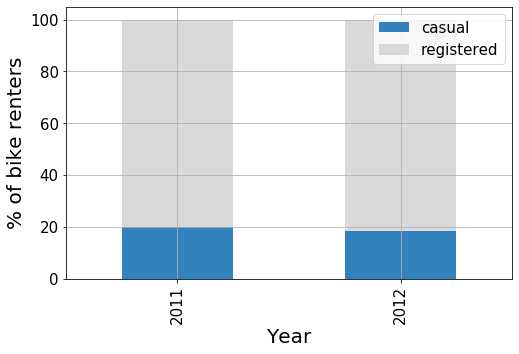

In [107]:
## since we cant see the trend or pattern, I suggest that we just keep table (Cheer)

# Plotting the % of both type of customers per year
year =['2011','2011','2012', '2012']
passengers= ['casual', 'registered', 'casual', 'registered']
numbers = [19.89, 80.11, 18.19, 81.81]
df = pd.DataFrame({'year': year, 'passengers': passengers, 'numbers': numbers})
df = df.pivot(columns='passengers',index='year').fillna(0)
df.plot(kind='bar',stacked=True,legend=False, figsize=(8,5), colormap = "tab20c", grid = True)
plt.legend(["casual", "registered"], fontsize=15)
plt.ylabel("% of bike renters", fontsize=20)
plt.xlabel("Year", fontsize=20)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)
plt.show()

The change in the total number of casuals and registered passengers is not significant from 2011 to 2012.

As we have seen before, both the number of casual and registered customers increase over time. (**delete, no relevant insight?)**. 

In [53]:
# Calculating the % of people per season who were casual vs registered
casual_season= hour.groupby("season")[["casual"]].sum()
registered_season= hour.groupby("season")[["registered"]].sum()
w = pd.merge(casual_season,registered_season, on="season")
w
sum0 =w.iloc[0].sum()
w.iloc[0] = round(w.iloc[0]/sum0 * 100, 2)
sum1 =w.iloc[1].sum()
w.iloc[1] = round(w.iloc[1]/sum1 * 100, 2)
sum2 =w.iloc[2].sum()
w.iloc[2] = round(w.iloc[2]/sum2 * 100, 2)
sum3 =w.iloc[3].sum()
w.iloc[3] = round(w.iloc[3]/sum3 * 100, 2)
w

,casual,registered
season,,
1,12.86,87.14
2,22.16,77.84
3,21.31,78.69
4,15.42,84.58


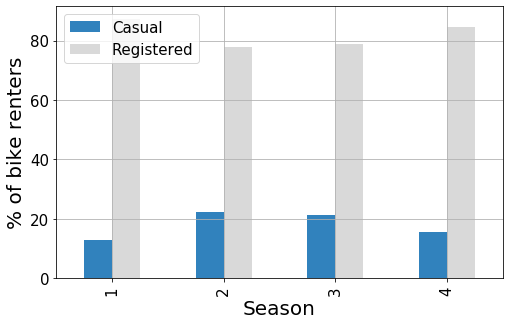

In [54]:
season =['1','1','2','2', '3', '3', '4', '4']
passengers= ['casual', 'registered', 'casual', 'registered', 'casual', 'registered', 'casual', 'registered']
numbers = [12.86, 87.14, 22.16, 77.84, 21.31, 78.69, 15.42, 84.58]
df = pd.DataFrame({'season': season, 'passengers': passengers, 'numbers': numbers})
df = df.pivot(columns='passengers',index='season').fillna(0)
df.plot(kind='bar',stacked=False,legend=False, figsize=(8,5),colormap = "tab20c" , grid = True)
plt.legend(["Casual", "Registered"], fontsize=15)
plt.ylabel("% of bike renters", fontsize=20)
plt.xlabel("Season", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

The percentage of casual vs registered customers changes slightly over time, with an increase in the proportion of casual customers over seasons 2 and 3. This might refer to customers who are on holiday and can use bikes on specific occasions. 

Text(0, 0.5, 'Registered')

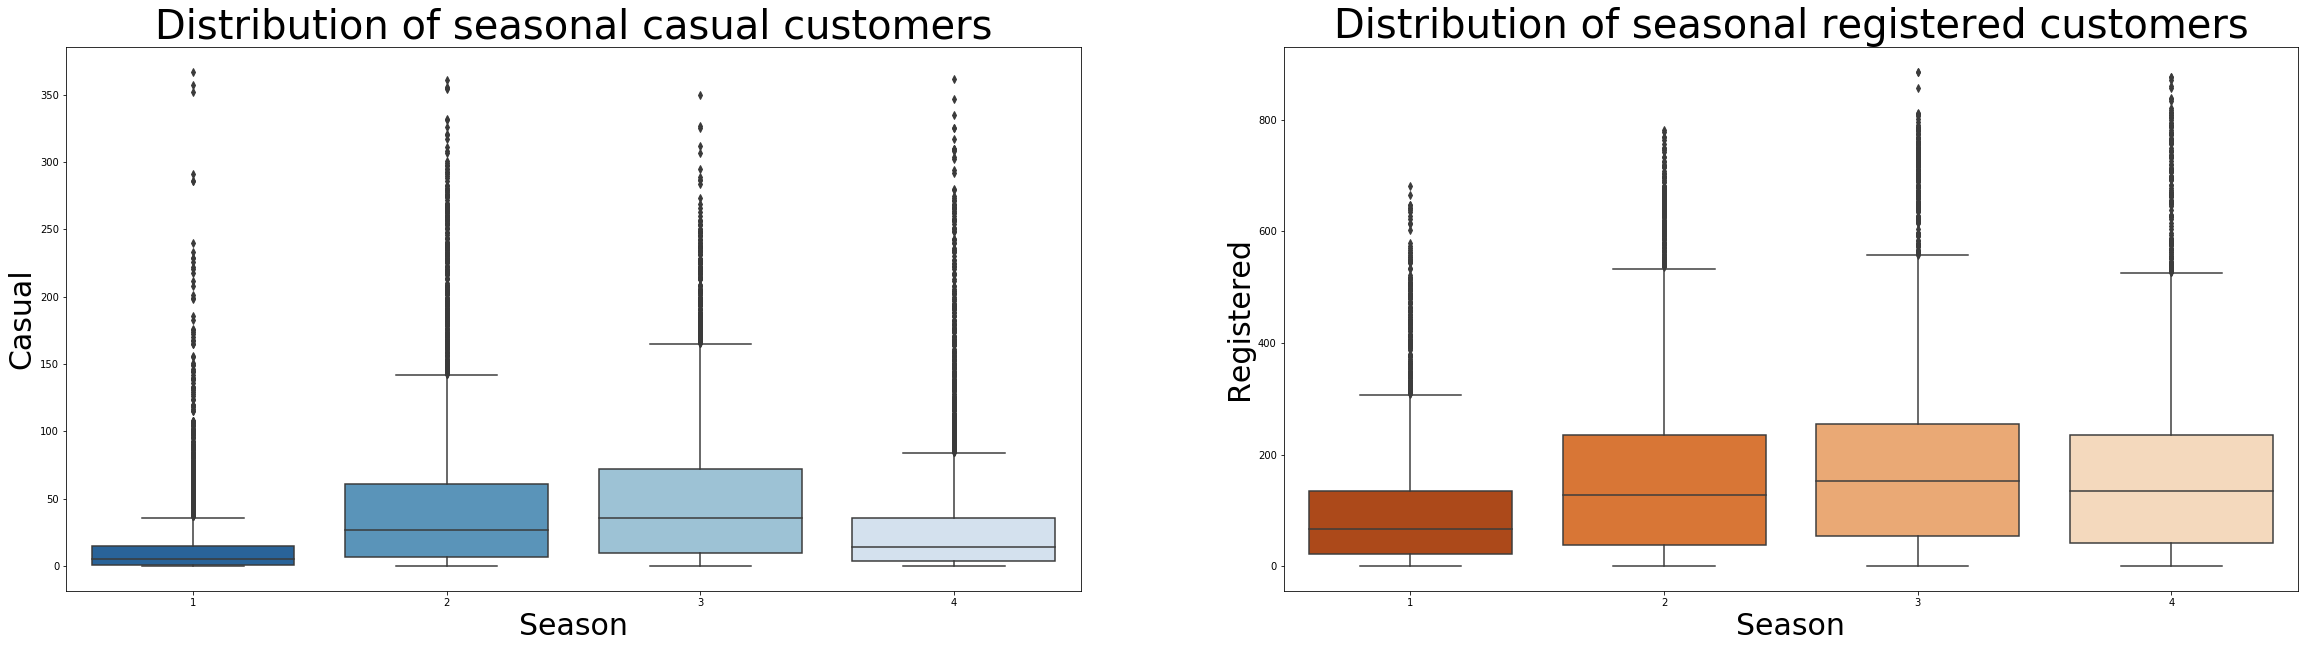

In [55]:
# I change teh palette back to what I did before, since using the same pattern will actually mislead the audience that we are describing the same variables 
# Seasonal distribution of casual vs registered
fig, (ax1, ax2)=plt.subplots(ncols=2, figsize=(40,10))
sns.boxplot(x=hour["season"], y=hour["casual"],data=hour,ax=ax1, palette="Blues_r")
ax1.set_title("Distribution of seasonal casual customers", fontsize=40)
ax1.set_xlabel("Season" , fontsize = 30)
ax1.set_ylabel("Casual" , fontsize = 30)
sns.boxplot(x=hour["season"], y=hour["registered"],data=hour, ax=ax2, palette="Oranges_r")
ax2.set_title("Distribution of seasonal registered customers", fontsize=40)
ax2.set_xlabel("Season" , fontsize = 30)
ax2.set_ylabel("Registered" , fontsize = 30)

Once again, it is possible to observe that the variation in the number of casual customers is relatively higher than the variation for registered customers. While they register the lowest number of customers in season 1, the decrease in season 4 is less significant for registered customers than for casual ones. 

In both cases, bikes are more rent in the period between May and October. However, it is possible to notice that the fluctuation is much higher for casual customers, who are almost inexistent in January, February and December. (**delete, no relevant insight?**) 

Text(0, 0.5, 'Registered')

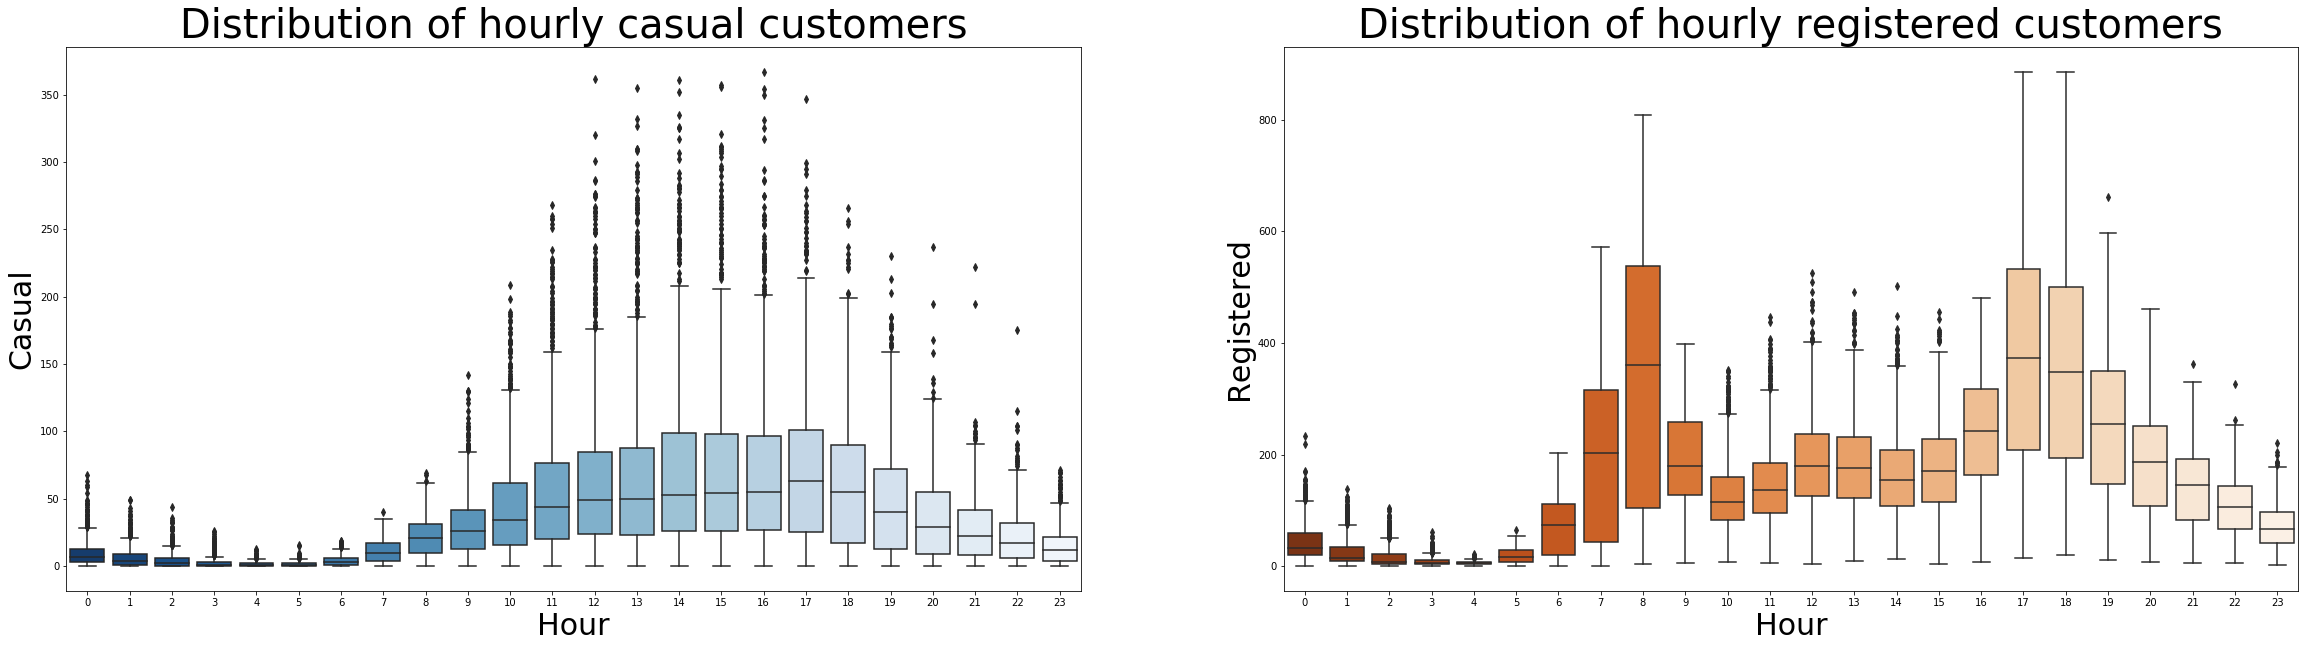

In [56]:
# Hourly distribution of casual vs registered
fig, (ax1, ax2)=plt.subplots(ncols=2, figsize=(40,10))
# sns.set_style("ticks", {"xtick.major.size": 2, "ytick.major.size": 1}) ## should this keep it?  since it doesnt shows on the graph (Cheer)
sns.boxplot(x=hour["hr"], y=hour["casual"],data=hour,ax=ax1, palette="Blues_r")
ax1.set_title("Distribution of hourly casual customers", fontsize=40)
ax1.set_xlabel("Hour" , fontsize = 30)
ax1.set_ylabel("Casual" , fontsize = 30)
sns.boxplot(x=hour["hr"], y=hour["registered"],data=hour, ax=ax2, palette="Oranges_r")
ax2.set_title("Distribution of hourly registered customers", fontsize=40)
ax2.set_xlabel("Hour" , fontsize = 30)
ax2.set_ylabel("Registered" , fontsize = 30)

While casual customers rent more bikes during the afternoon, for registered customers there are some observeble spikes in the morning and in the afternoon. As mentioned before, it is probably related with the usage of the bikes by registered customers, who use them to commute within the city. 

Text(0, 0.5, 'Registered')

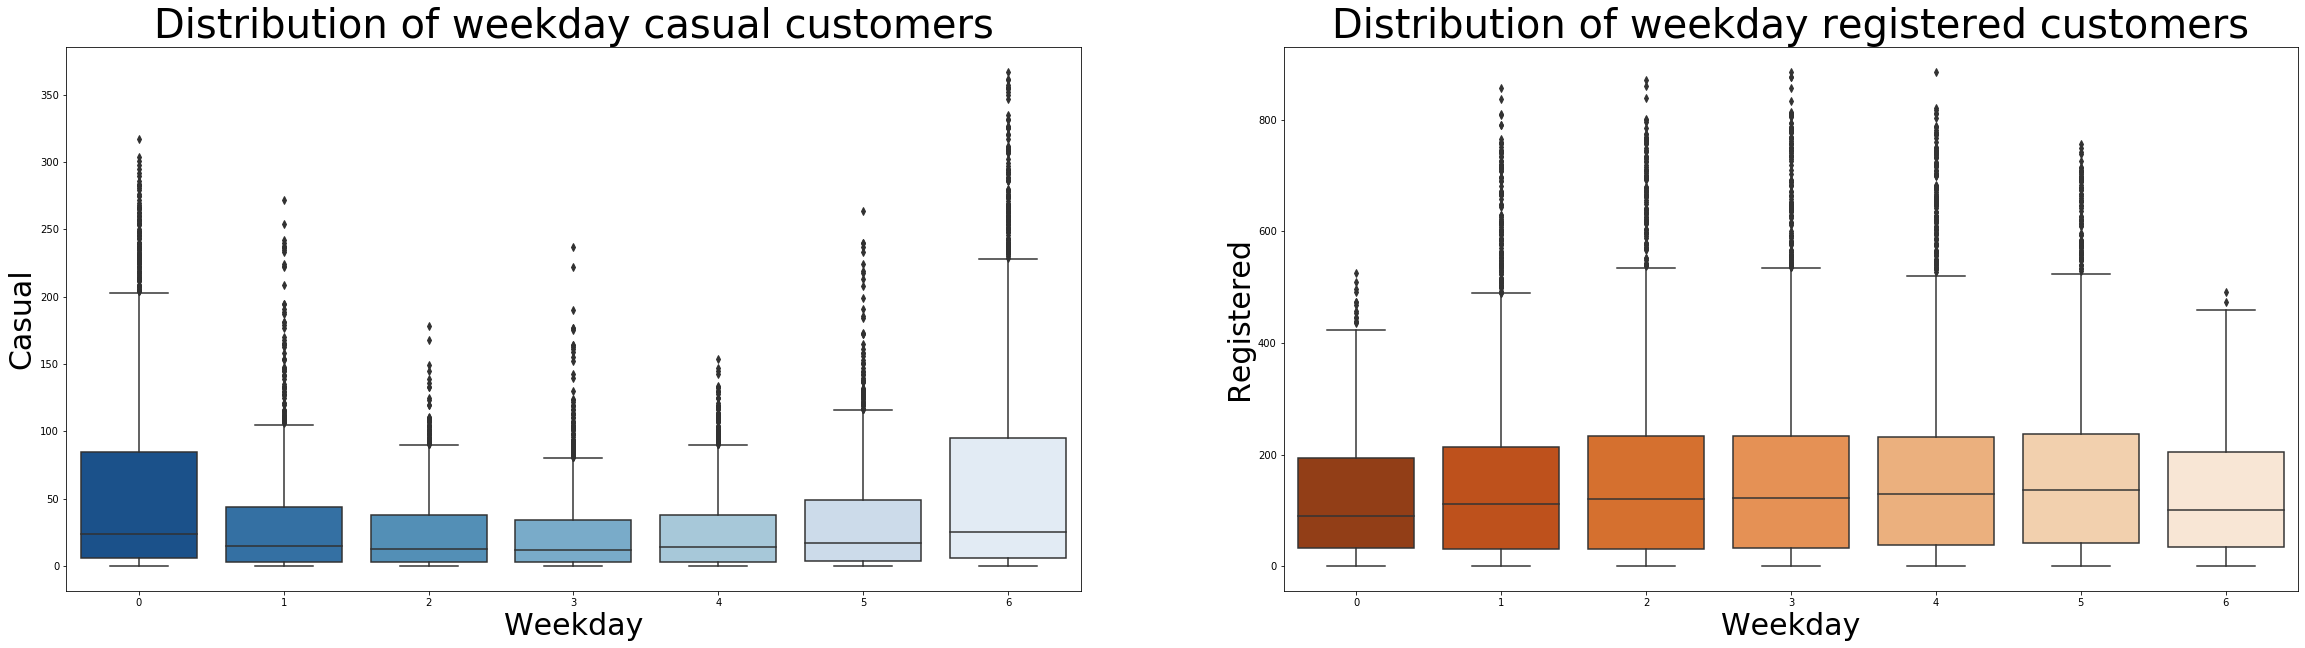

In [57]:
# Weekday distribution of casual vs registered
fig, (ax1, ax2)=plt.subplots(ncols=2, figsize=(40,10))
sns.boxplot(x=hour["weekday"], y=hour["casual"],data=hour,ax=ax1,palette="Blues_r")
ax1.set_title("Distribution of weekday casual customers", fontsize=40)
ax1.set_xlabel("Weekday" , fontsize = 30)
ax1.set_ylabel("Casual" , fontsize = 30)
sns.boxplot(x=hour["weekday"], y=hour["registered"],data=hour, ax=ax2, palette="Oranges_r")
ax2.set_title("Distribution of weekday registered customers", fontsize=40)
ax2.set_xlabel("Weekday" , fontsize = 30)
ax2.set_ylabel("Registered" , fontsize = 30)

Casual customers tend to rent more bikes on the weekend, whereas registered customers are more regular in their bike rentings. A small decrease can be observed on the weekends for registered customers. 

Text(0.5, 1.0, 'Bicycle usage hourly during weekdays')

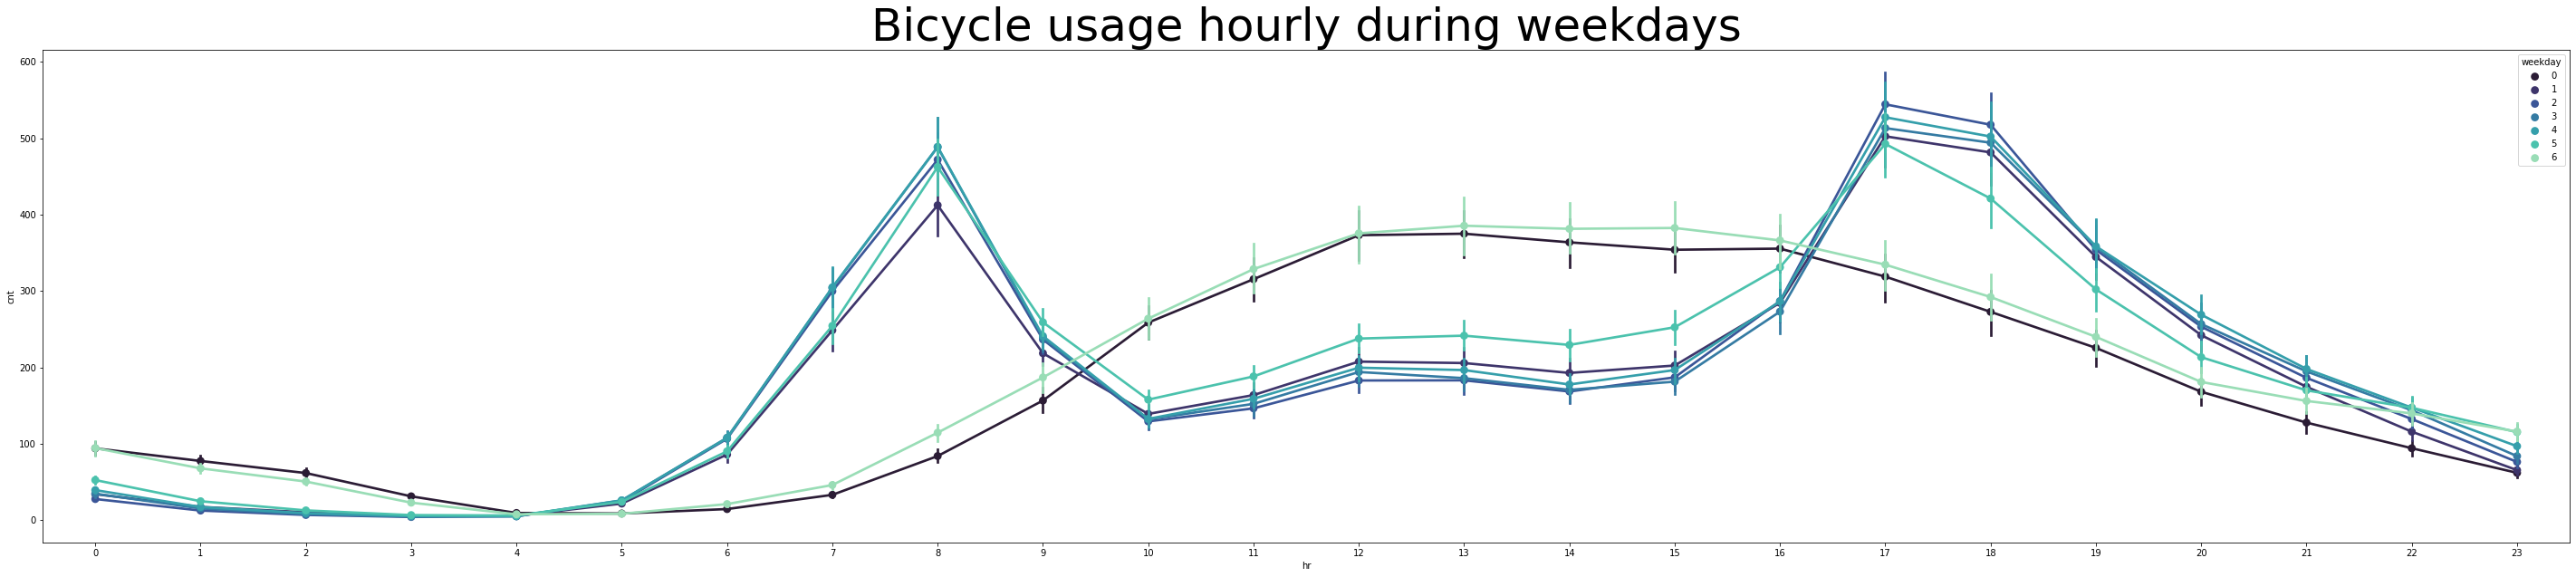

In [58]:
# Bicycle Usage per hour per weekday
fig, ax = plt.subplots(figsize=(50, 10))
sns.pointplot(data=hour[["hr", "cnt", "weekday"]], x="hr", y="cnt", hue="weekday", ax=ax, palette = "mako")
ax.set_title("Bicycle usage hourly during weekdays", fontsize=50)

The proportion of casual customers is much higher on workingdays comparing to non-working days. It is in accordance with the analysis that have already been done. 

The is a heavy decrease in the proportion of casual customers when the weather conditions are not favourable, meaning that probably casual customers mostly use bikes for leisure reasons. 

Text(0, 0.5, 'Registered')

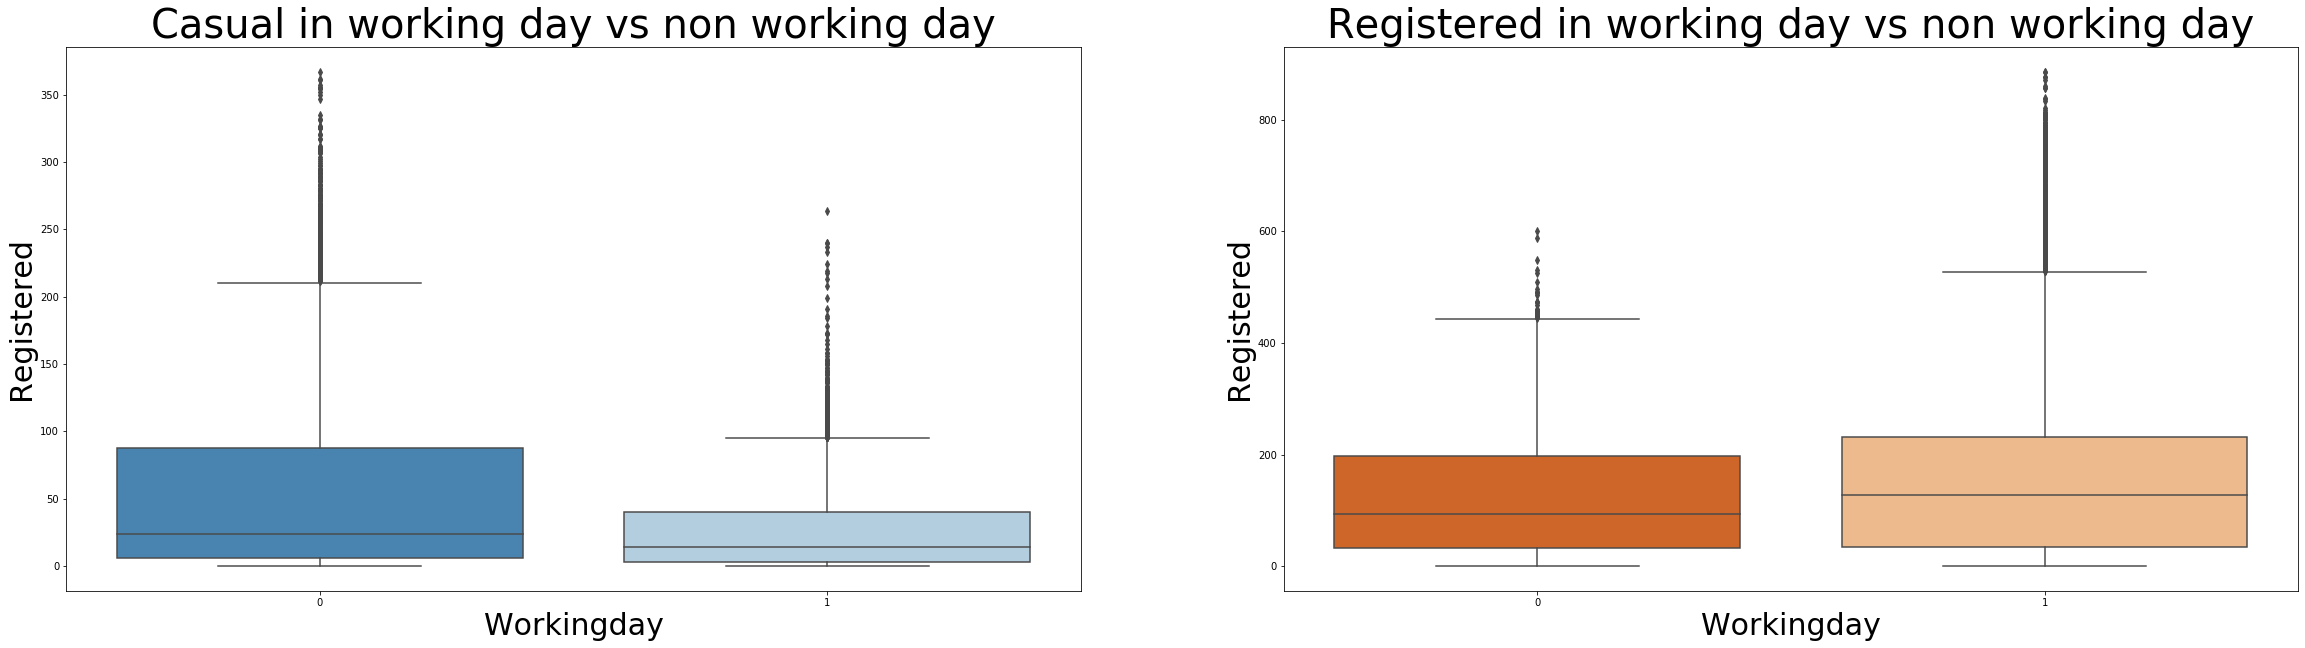

In [59]:
#  Workingday vs non workingday distribution of casual vs registered
fig, (ax1, ax2)=plt.subplots(ncols=2, figsize=(40,10))
sns.boxplot(x=hour["workingday"], y=hour["casual"],data=hour,ax=ax1, palette="Blues_r")
ax1.set_title("Casual in working day vs non working day",fontsize =40)
ax1.set_xlabel("Workingday" , fontsize = 30)
ax1.set_ylabel("Registered" , fontsize = 30)
sns.boxplot(x=hour["workingday"], y=hour["registered"],data=hour, ax=ax2, palette="Oranges_r")
ax2.set_title("Registered in working day vs non working day", fontsize =40)
ax2.set_xlabel("Workingday" , fontsize = 30)
ax2.set_ylabel("Registered" , fontsize = 30)

Text(0, 0.5, 'Registered')

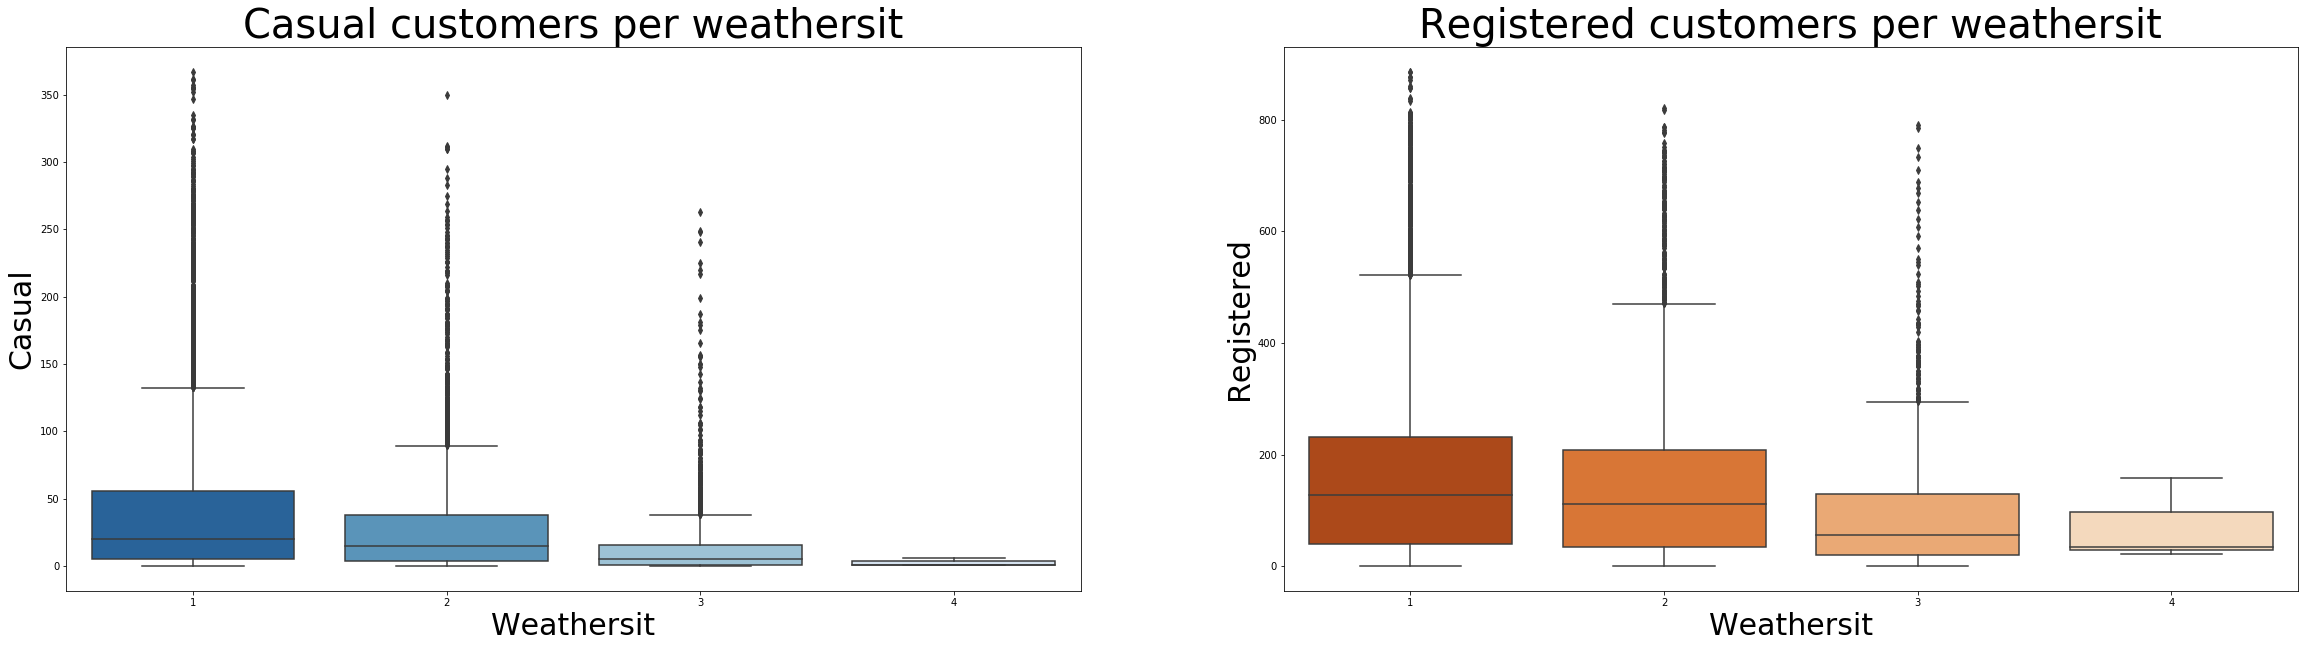

In [60]:
#  Weathersit distribution of casual vs registered 
fig, (ax1, ax2)=plt.subplots(ncols=2, figsize=(40,10))
sns.boxplot(x=hour["weathersit"], y=hour["casual"],data=hour,ax=ax1,palette="Blues_r")
ax1.set_title("Casual customers per weathersit",fontsize=40)
ax1.set_xlabel("Weathersit", fontsize = 30)
ax1.set_ylabel("Casual" , fontsize = 30)
sns.boxplot(x=hour["weathersit"], y=hour["registered"],data=hour, ax=ax2,palette="Oranges_r")
ax2.set_title("Registered customers per weathersit", fontsize=40)
ax2.set_xlabel("Weathersit", fontsize = 30)
ax2.set_ylabel("Registered" , fontsize = 30)

### Numerical analysis - Temp & Atemp & Hum & Windspeed
Visualize the numerical variables and see how do they change with respect to the target variable? 

#### Defination of Temp & Atemp

**Definition of Temp :**\
    Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)\
**Definition of Atemp:**\
    Normalized feeling temperature in Celsius. \
    The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)

Text(0, 0.5, 'count')

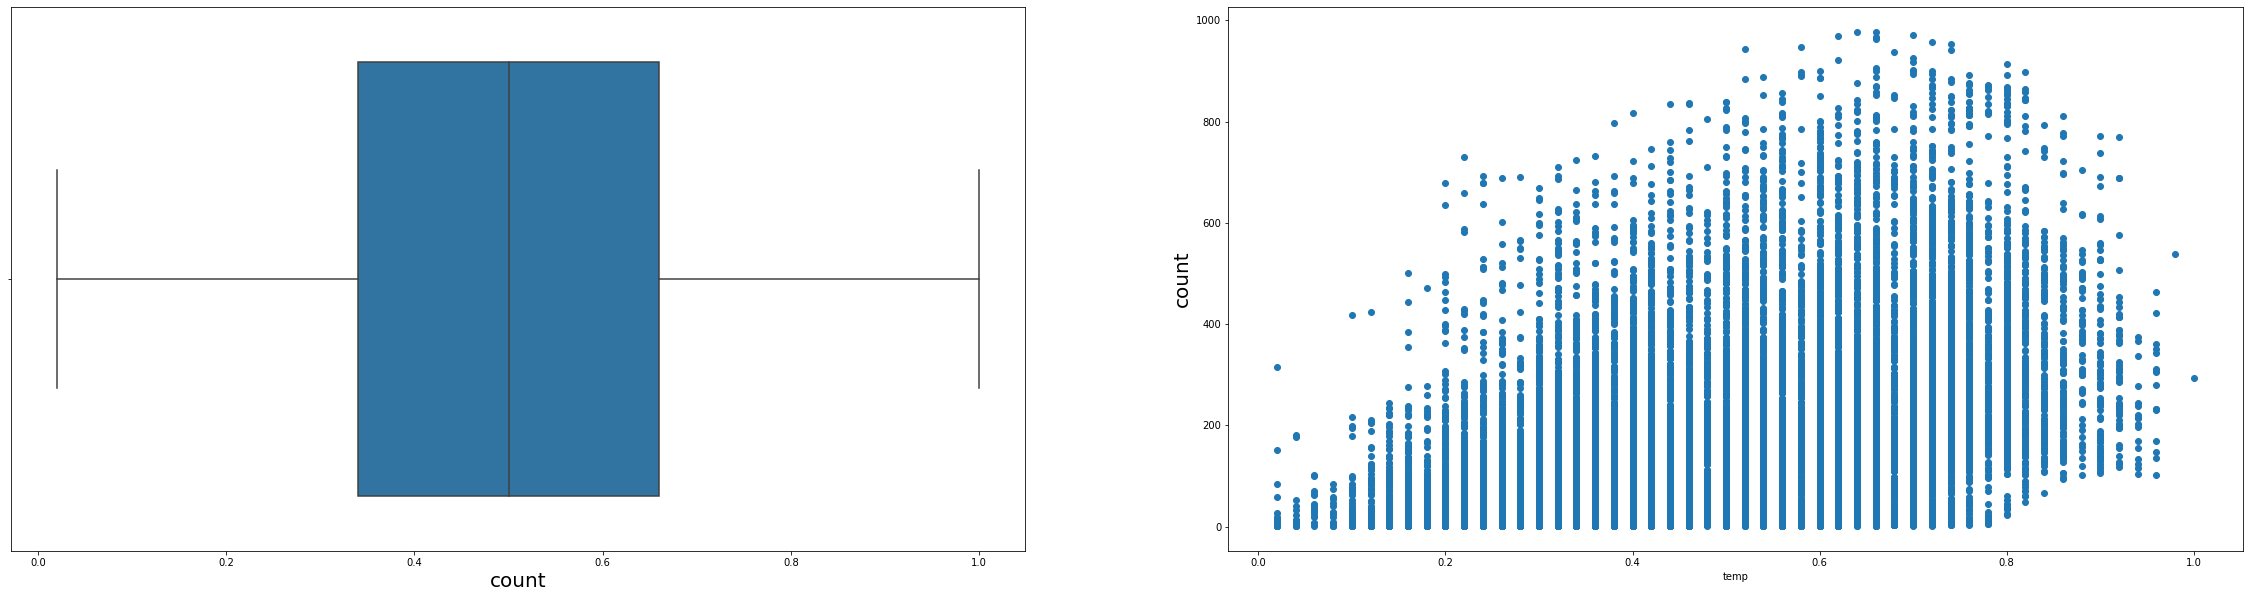

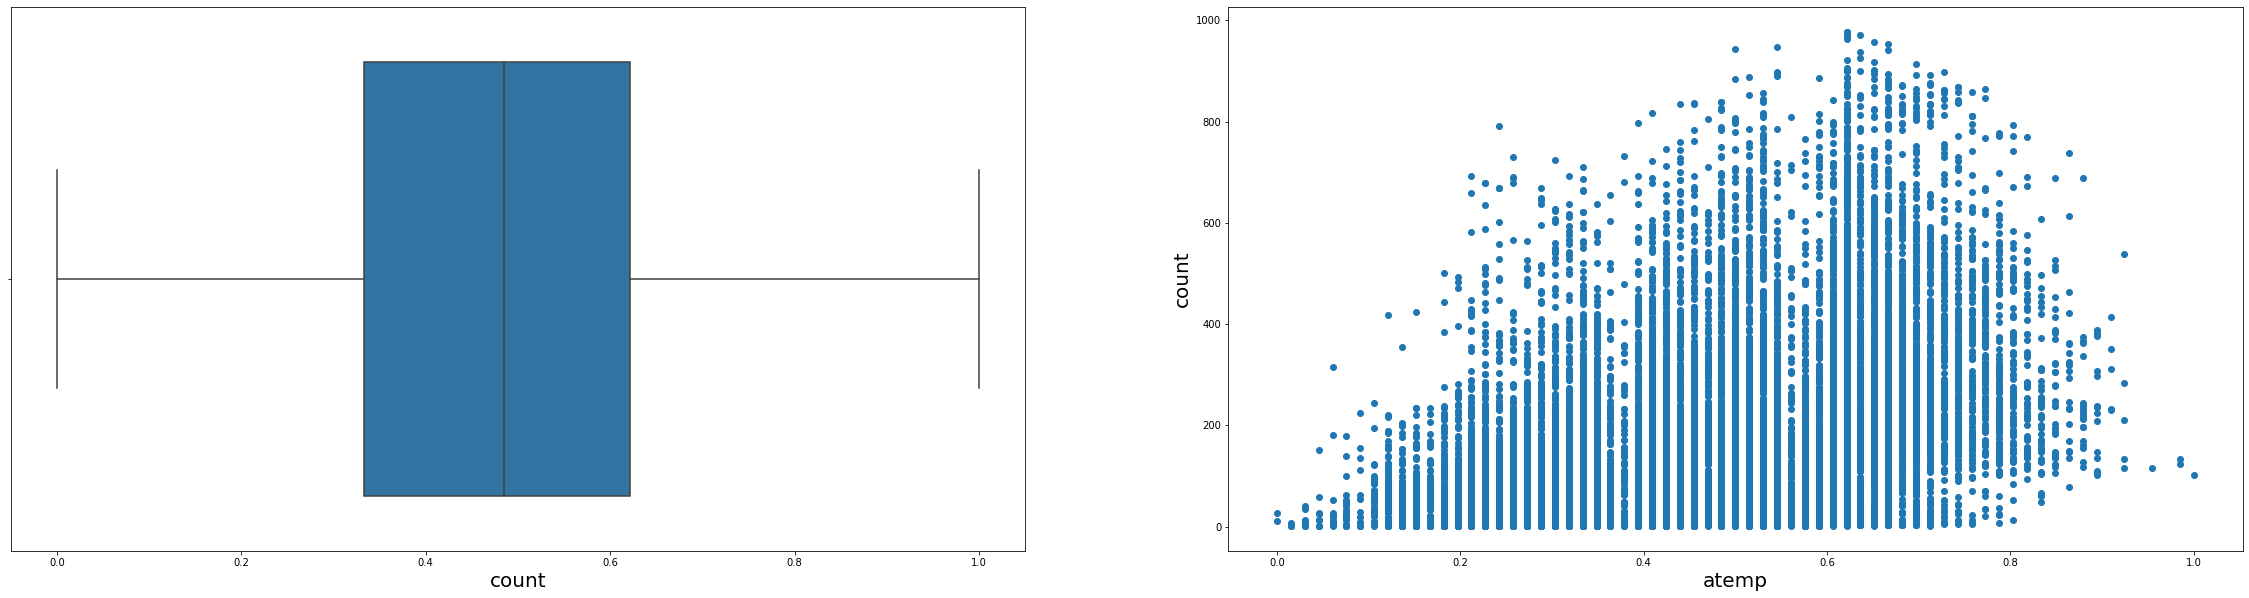

In [61]:
fig, (ax1, ax2)=plt.subplots(ncols=2, figsize=(40,10))
sns.boxplot(hour.temp, ax= ax1) 
ax1.set_xlabel("count",fontsize = 20)
ax2 = plt.scatter(hour.temp, hour.cnt)
plt.xlabel("temp",fontsize = 10)
plt.ylabel("count",fontsize = 20)
fig, (ax3, ax4)=plt.subplots(ncols=2, figsize=(40,10))
sns.boxplot(hour.atemp, ax= ax3) 
ax3.set_xlabel("count",fontsize = 20)
ax4 = plt.scatter(hour.atemp, hour.cnt)
plt.xlabel("atemp",fontsize = 20)
plt.ylabel("count",fontsize = 20)

There seem to be no outliers neither for "temp" nor for "attemp". Both variables are normalized, but seems that temp is perfectly distributed with a median value of 0.5. From the correlations, it is possible to observe that the higher the temperature and the feeling of the temperature, the higher the number of people renting bikes. 

#### Definition of windspeed:
Normalized wind speed. The values are divided to 67 (max)

Text(0.5, 0, 'windspeed')

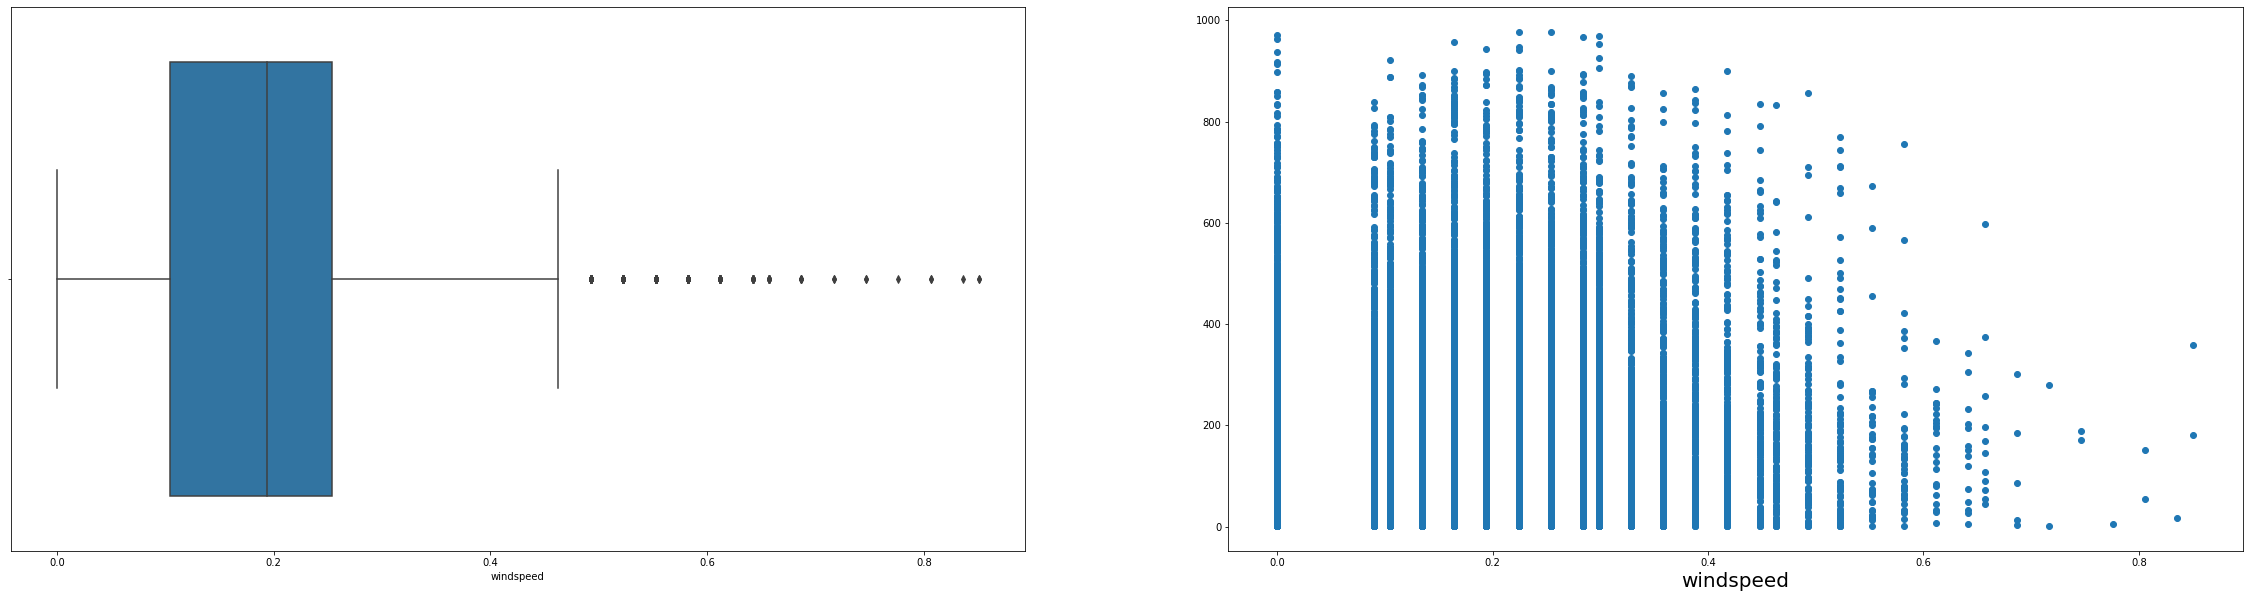

In [62]:
fig, (ax1, ax2)=plt.subplots(ncols=2, figsize=(40,10))
sns.boxplot(hour.windspeed, ax= ax1) # No outliers (only a few)
# Plotting the relationship between humidity and cnt 
ax2 = plt.scatter(hour.windspeed, hour.cnt)
plt.xlabel("windspeed", fontsize = 20)

There are some outliers in the windspeed variable. At the same time, and even though it is a continuous variable, windspeed seems to behave like a categorical variable (multiple categories). 

#### Definition of hum:
Normalized humidity. The values are divided to 100 (max)

Text(0, 0.5, 'cnt')

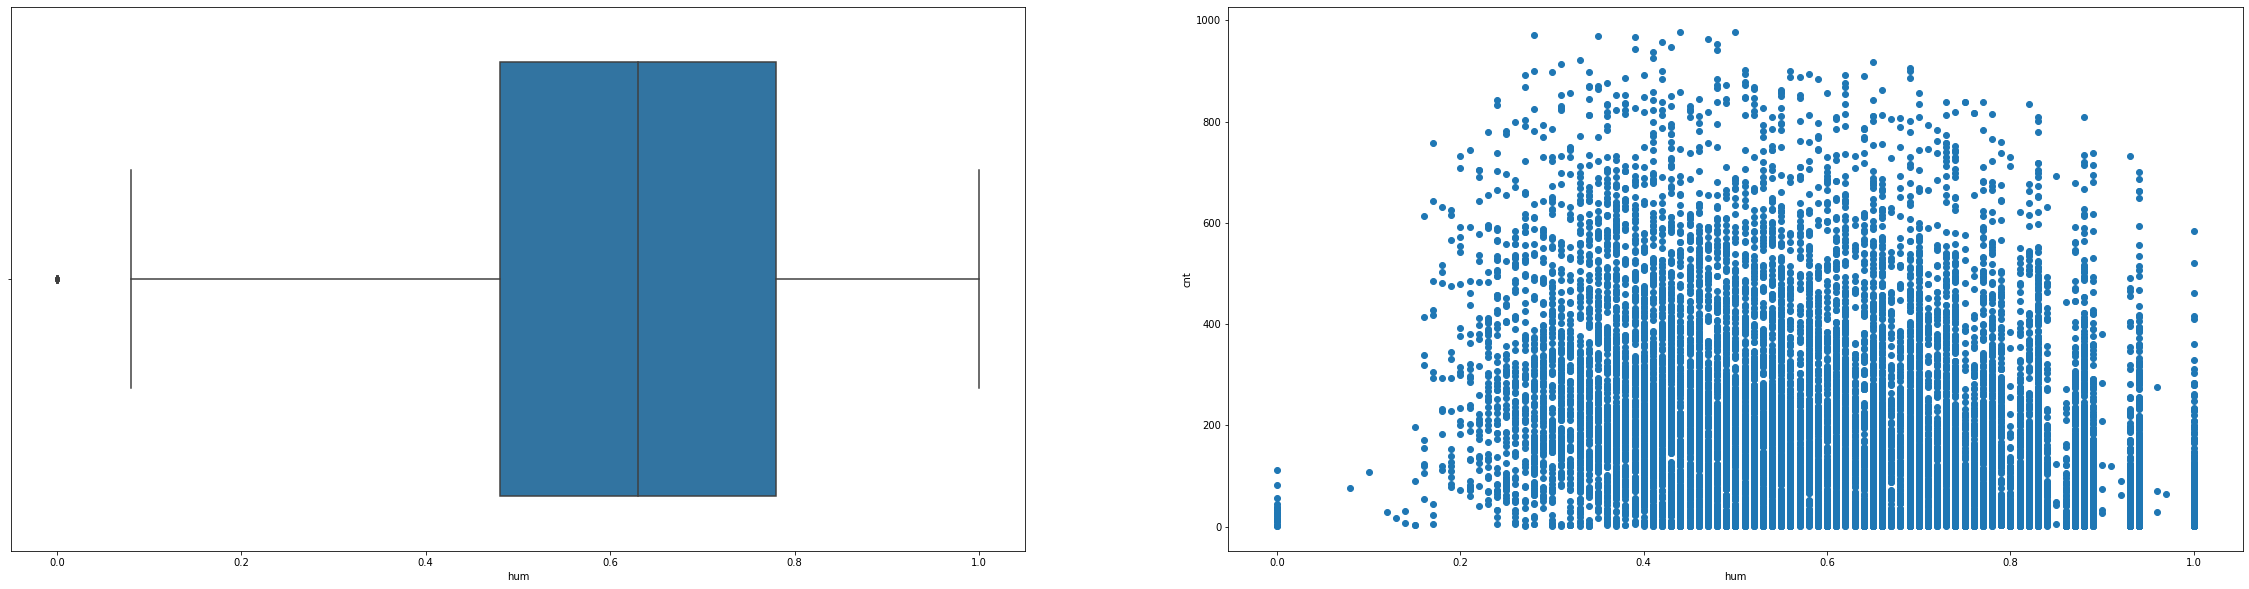

In [63]:
fig, (ax1, ax2)=plt.subplots(ncols=2, figsize=(40,10))
sns.boxplot(hour.hum, ax= ax1) # No outliers (only a few)

# Plotting the relationship between humidity and cnt 
ax2 = plt.scatter(hour.hum, hour.cnt)
plt.xlabel("hum")
plt.ylabel("cnt")

Normally, we will eliminate the outlier, however this case consider timeline as one of the dimensions.
Removing the outlier would imply removing time frames from the dataset which 

Text(0, 0.5, 'hum')

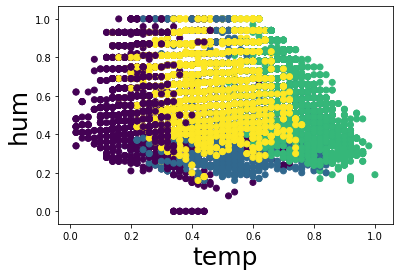

In [64]:
# what is the purpose of this graph (Cheer)
# Is there a relationship between temperature and humidity? ()
%matplotlib inline
ax1 = plt.scatter(hour.temp, hour.hum, c=hour.season)
plt.xlabel("temp", fontsize=25)
plt.ylabel("hum", fontsize=25)

### remove this becuase (the humidity is normalised so stating 60% does not really say a lot, also the link is referring to 2019 and the data is talking about 2011 & 2012)
The average humidity in washington D.C is around 60%. There seems to be a low correlation between humidity and the number of people renting bikes, since a lower humidity level does not seem to increase the number of people renting bikes.
Resources: https://weather-and-climate.com/average-monthly-Humidity-perc,Washington-DC,United-States-of-America

***After doing all the visualization, we assumed that some variables n=might have the possibility to descibe others, so we want to go through the correlation heatmap, making sure if there is any variable need to drop.***

## Analyzing correlation

In [65]:
# Checking correlations 
correlation_matrix= hour.corr()
correlation_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)

,temp,atemp,hum,windspeed,casual,registered,cnt,hr2,season2,temp2,hum2,weekday2
temp,1,0.99,-0.07,-0.023,0.46,0.34,0.4,0.14,0.31,1,-0.07,-0.0018
atemp,0.99,1,-0.052,-0.062,0.45,0.33,0.4,0.13,0.32,0.99,-0.052,-0.0088
hum,-0.07,-0.052,1,-0.29,-0.35,-0.27,-0.32,-0.28,0.15,-0.07,1,-0.037
windspeed,-0.023,-0.062,-0.29,1,0.09,0.082,0.093,0.14,-0.15,-0.023,-0.29,0.012
casual,0.46,0.45,-0.35,0.09,1,0.51,0.69,0.3,0.12,0.46,-0.35,0.033
registered,0.34,0.33,-0.27,0.082,0.51,1,0.97,0.37,0.17,0.34,-0.27,0.022
cnt,0.4,0.4,-0.32,0.093,0.69,0.97,1,0.39,0.18,0.4,-0.32,0.027
hr2,0.14,0.13,-0.28,0.14,0.3,0.37,0.39,1,-0.0061,0.14,-0.28,-0.0035
season2,0.31,0.32,0.15,-0.15,0.12,0.17,0.18,-0.0061,1,0.31,0.15,-0.0023
temp2,1,0.99,-0.07,-0.023,0.46,0.34,0.4,0.14,0.31,1,-0.07,-0.0018


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text xticklabel objects>)

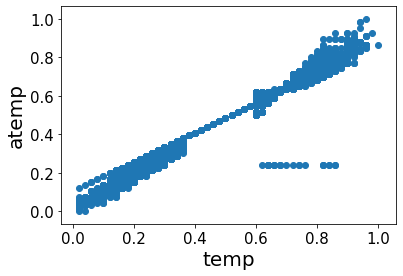

In [66]:
# Plotting the temp in relationship with attemp (highly correlated)
plt.scatter(hour.temp, hour.atemp)
plt.xlabel("temp", fontsize = 20)
plt.ylabel("atemp", fontsize = 20)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)

***According to the corr. heatmap and the scatter plot above we find out that temp & atemp are highly correlated 
we should drop atemp to avoid multicollinearity.***

* There was an increase in bike renting from year 2011 to year 2012.
* However, the trend for number of bikes rented based on seasons is the same each year, so the rental of bike is seasonal.
* Bikes are least rented in Spring and the most during Fall.
* After Spring, there is a sudden increase in bike renting during summer.

## Dealing With Skewness

For normally distributed data, the skewness should be about 0. A skewness value > 0 means that there is more weight in the left tail of the distribution. The function skew can be used to determine if the skewness value is close enough to 0, statistically speaking.

Lets analyse the skewness of each numerical variable visually and using the skew formula.

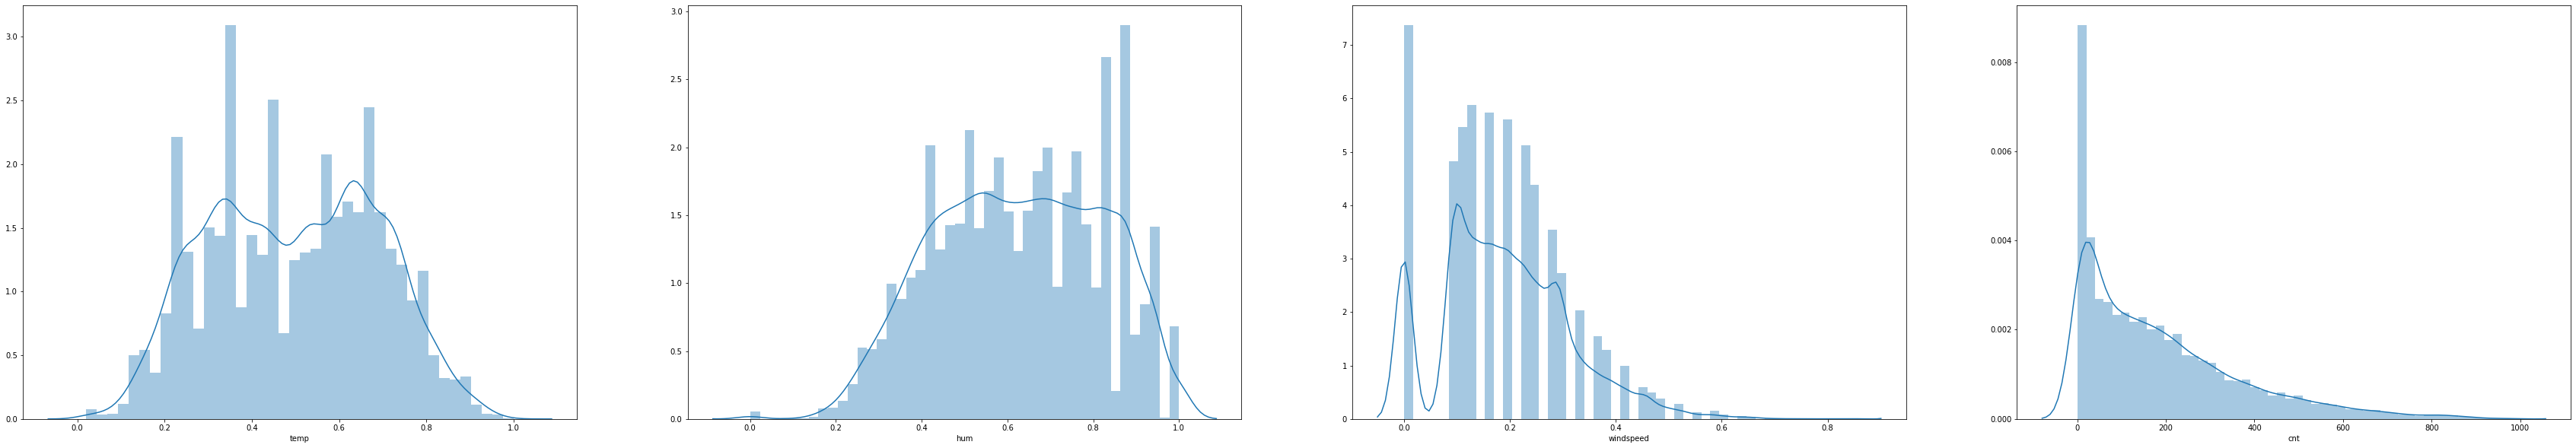

In [67]:
# Plot temp on y bar
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4,figsize=(60, 10))

sns.distplot(hour["temp"], ax=ax1)
sns.distplot(hour["hum"], ax=ax2)
sns.distplot(hour["windspeed"],ax=ax3)
sns.distplot(hour["cnt"],ax=ax4)

In [68]:
temp = round(hour["temp"].skew(),5)
print ("the skew of temp is", temp) 
hum = round(hour["hum"].skew(),5)
print ("the skew of hum is", hum) 
windspeed = round(hour["windspeed"].skew(),5)
print ("the skew of windspeed is", windspeed) 
cnt = round(hour["cnt"].skew(),5)
print ("the skew of cnt is", cnt) 

the skew of temp is -0.00602
the skew of hum is -0.11129
the skew of windspeed is 0.57491
the skew of cnt is 1.27741


* The test for 'temp', 'hum' do not show skewness so no transformation will be made.
* 'windspeed' and 'cnt' looks skewed, and the skew test confirm the skewness. We will first try to take the log:

#### Windspeed

In [69]:
from scipy.stats import skew
# Log of the count since log0 is invalid so we use log1p.  
logws = round(skew(np.log1p(hour.windspeed)),4)
print ("log of the windspeed is", logws) 
# Sqrt of the count
sqrtws = round(skew(np.sqrt(hour.windspeed)),4)
print ("sqrt of the windspeed is", sqrtws) 

log of the windspeed is 0.2639
sqrt of the windspeed is -0.8899


* Taking the log resolved the problem of skewness

In [70]:
hour["windspeed"] = np.log1p(hour.windspeed)

#### CNT

In [71]:
from scipy.stats import skew
# Log of the count
logcnt = round(skew(np.log(hour.cnt)),4)
print ("log of the count is", logcnt) 
# Sqrt of the count
sqrtcnt = round(skew(np.sqrt(hour.cnt)),4)
print ("sqrt of the count is", sqrtcnt) 

log of the count is -0.9361
sqrt of the count is 0.2864


* Taking the sqrt resolved the problem of skewness

In [72]:
hour["cnt"] = np.sqrt(hour.cnt)

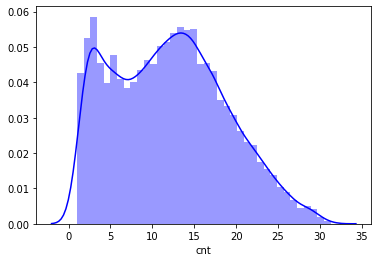

In [73]:
sns.distplot(hour["cnt"], color = "Blue")

## Feature Engineering

In [74]:
#Rented during office hours
hour['IsOfficeHour'] = np.where((hour['hr2'] >= 9) & (hour['hr2'] < 17) & (hour['weekday2'] == 1), 1 ,0)
hour['IsOfficeHour'] = hour['IsOfficeHour'].astype('category')

#Rented during daytime
hour['IsDaytime'] = np.where((hour['hr2'] >= 6) & (hour['hr2'] < 22), 1 ,0)
hour['IsDaytime'] = hour['IsDaytime'].astype('category')

#Rented during morning rush hour
hour['IsRushHourMorning'] = np.where((hour['hr2'] >= 6) & (hour['hr2'] < 10)  & (hour['weekday2'] == 1), 1 ,0)
hour['IsRushHourMorning']=hour['IsRushHourMorning'].astype('category')

#Rented during evening rush hour
hour['IsRushHourEvening'] = np.where((hour['hr2'] >= 15) & (hour['hr2'] < 19) & (hour['weekday2'] == 1), 1 ,0)
hour['IsRushHourEvening'] = hour['IsRushHourEvening'].astype('category')

#Rented during most busy season
hour['IsHighSeason'] = np.where((hour['season2'] == 3), 1 ,0)
hour['IsHighSeason'] = hour['IsHighSeason'].astype('category')

#binning temp, atemp, hum in 5 equally sized bins
bins = [0, 0.19, 0.49, 0.69, 0.89, 1]
hour['temp_binned'] = pd.cut(hour['temp2'], bins).astype('category')
hour['hum_binned'] = pd.cut(hour['hum2'], bins).astype('category')

In [75]:
#dropping duplicated rows used for feature engineering
hour = hour.drop(columns = ['hr2','season2', 'temp2', 'hum2', 'weekday2'])

In [76]:
hour.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,...,casual,registered,cnt,IsOfficeHour,IsDaytime,IsRushHourMorning,IsRushHourEvening,IsHighSeason,temp_binned,hum_binned
instant,,,,,,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,...,3,13,4.000000,0,0,0,0,0,"(0.19, 0.49]","(0.69, 0.89]"
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,...,8,32,6.324555,0,0,0,0,0,"(0.19, 0.49]","(0.69, 0.89]"
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,...,5,27,5.656854,0,0,0,0,0,"(0.19, 0.49]","(0.69, 0.89]"
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,...,3,10,3.605551,0,0,0,0,0,"(0.19, 0.49]","(0.69, 0.89]"
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,...,0,1,1.000000,0,0,0,0,0,"(0.19, 0.49]","(0.69, 0.89]"


In [77]:
hour = pd.get_dummies(hour)

In [78]:
correlation_matrix= hour.corr()
correlation_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)

# Split the data into train and test as outliers can only be removed from train

## Set the Training Data and Test Data

Training data: whole 2011 and first 3 quarters of 2012.\
Test data: 4th quarter of 2012.  Do not fit your models with these data! They should just be used to see how good/bad your model predictions are.

In [79]:
hour_train = hour.iloc[0:15211]
hour_test = hour.iloc[15212:17379]

In [80]:
round(hour_train.describe(),3)

,temp,atemp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,...,"temp_binned_(0.0, 0.19]","temp_binned_(0.19, 0.49]","temp_binned_(0.49, 0.69]","temp_binned_(0.69, 0.89]","temp_binned_(0.89, 1.0]","hum_binned_(0.0, 0.19]","hum_binned_(0.19, 0.49]","hum_binned_(0.49, 0.69]","hum_binned_(0.69, 0.89]","hum_binned_(0.89, 1.0]"
count,15211.000,15211.000,15211.000,15211.000,15211.000,15211.000,15211.000,15211.000,15211.000,15211.000,...,15211.000,15211.000,15211.000,15211.000,15211.000,15211.000,15211.000,15211.000,15211.000,15211.000
mean,0.513,0.489,0.625,0.170,36.239,148.987,11.878,0.262,0.290,0.296,...,0.046,0.390,0.344,0.209,0.011,0.003,0.284,0.315,0.328,0.069
std,0.196,0.175,0.196,0.101,49.430,146.922,6.643,0.440,0.454,0.456,...,0.210,0.488,0.475,0.406,0.106,0.058,0.451,0.464,0.469,0.253
min,0.020,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.340,0.333,0.470,0.099,4.000,33.000,6.245,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.540,0.500,0.620,0.177,17.000,112.000,11.747,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.660,0.621,0.780,0.226,50.000,213.000,16.583,1.000,1.000,1.000,...,0.000,1.000,1.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000
max,1.000,1.000,1.000,0.616,367.000,886.000,31.257,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


# Finally start with Machine Learning 


In [81]:
train = hour_train.drop(columns = ['dteday', 'casual','atemp', 'registered'])
test = hour_test.drop(columns = ['dteday', 'casual', 'registered','atemp'])

In [82]:
# seperate the independent and target variable on testing data
train_X = train.drop(columns=['cnt'],axis=1)
train_y = train['cnt']

# seperate the independent and target variable on test data
test_X = test.drop(columns=['cnt'],axis=1)
test_y = test['cnt']

## Lasso

In [83]:
lasso = Lasso()
lasso.fit(train_X, train_y)
result_lasso = lasso.predict(test_X)

print("R-squared for Train: %.2f" % lasso.score(train_X, train_y))
print("R-squared for Test: %.2f" % lasso.score(test_X, test_y))


RMSE = np.sqrt(np.mean((test_y** 2 - result_lasso ** 2) ** 2))
MSE = RMSE ** 2

print("MSE ={}".format(MSE))
print("RMSE = {}".format(RMSE))

R-squared for Train: 0.32
R-squared for Test: 0.31
MSE =36772.10143740291
RMSE = 191.7605314901972


## Ridge

In [84]:
ridge = Ridge()
ridge.fit(train_X, train_y)
result_ridge = ridge.predict(test_X)

print("R-squared for Train: %.2f" % ridge.score(train_X, train_y))
print("R-squared for Test: %.2f" % ridge.score(test_X, test_y))


RMSE = np.sqrt(np.mean((test_y** 2 - result_ridge ** 2) ** 2))
MSE = RMSE ** 2

print("MSE ={}".format(MSE))
print("RMSE = {}".format(RMSE))

R-squared for Train: 0.80
R-squared for Test: 0.75
MSE =12682.87436572568
RMSE = 112.61826834810452


# Decision Trees

In [85]:
dt1 = DecisionTreeRegressor(max_depth=10, min_samples_split=5,max_leaf_nodes=40, random_state=42)
dt1.fit(train_X,train_y)

y_pred = dt1.predict(train_X)
y_pred_test = dt1.predict(test_X)

r2_train = dt1.score(train_X, train_y) # R2 train
r2_test = dt1.score(tes_X, test_y) # R2 test

print("R-squared for Train: %.2f" % dt1.score(train_X, train_y))
print("R-squared for Test: %.2f" % dt1.score(test_X, test_y))

RMSE = np.sqrt(np.mean((test_y** 2 - y_pred_test ** 2) ** 2))
MSE = RMSE ** 2

print("MSE ={}".format(MSE))
print("RMSE = {}".format(RMSE))


NameError: name 'tes_X' is not defined

In [ ]:
gsc = GridSearchCV(
    estimator=DecisionTreeRegressor(),# Use decision tree regressor 
    param_grid={"max_depth": (10, 50, 100, 200), "min_samples_split":(5,10,20,40), "max_leaf_nodes":(10,20,100, None)},   # understand the parameters
    cv=5,
    scoring="r2",
    verbose=10, # set this to 10 if it takes too much time 
    n_jobs=4,
)

grid_result = gsc.fit(train_X, train_y)

In [ ]:
gsc.best_params_

In [ ]:
dt3 = DecisionTreeRegressor(max_depth=200, min_samples_split=40,max_leaf_nodes=None, random_state=42)

dt3.fit(train_X, train_y)

result_dt = dt3.predict(test_X)

r2_train = dt3.score(train_X, train_y) # R2 train
r2_test = dt3.score(train_X, train_y) # R2 test


print("R-squared for Train: %.2f" % dt3.score(train_X, train_y))
print("R-squared for Test: %.2f" % dt3.score(test_X, test_y))

RMSE = np.sqrt(np.mean((test_y** 2 - result_dt ** 2) ** 2))
MSE = RMSE ** 2

print("MSE ={}".format(MSE))
print("RMSE = {}".format(RMSE))

# Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators = 50, random_state = 42)
rf.fit(train_X, train_y)
result = rf.predict(test_X)



print("R-squared for Train: %.2f" % rf.score(train_X, train_y))
print("R-squared for Test: %.2f" % rf.score(test_X, test_y))


RMSE = np.sqrt(np.mean((test_y ** 2 - result ** 2) ** 2))
MSE = RMSE ** 2

print("MSE ={}".format(MSE))
print("RMSE = {}".format(RMSE))

In [ ]:
gsc = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={ 'max_depth': [10, 40, ],
                 'min_samples_leaf': [1, 2],
                 'min_samples_split': [2, 5],
                 'n_estimators': [200, 400]},
    cv=5,
    scoring="r2",
    verbose=10,
    n_jobs=4,
)

grid_result = gsc.fit(train_X, train_y)

In [ ]:
gsc.best_params_

In [ ]:
rf = RandomForestRegressor(max_depth = 40,
                           min_samples_leaf = 1,
                           min_samples_split = 2,
                           n_estimators= 200,
                           random_state = 42)
rf.fit(train_X, train_y)
result_rf = rf.predict(test_X)



print("R-squared for Train: %.2f" % rf.score(train_X, train_y))
print("R-squared for Test: %.2f" % rf.score(test_X, test_y))


RMSE = np.sqrt(np.mean((test_y** 2 - result_rf ** 2) ** 2))
MSE = RMSE ** 2

print("MSE ={}".format(MSE))
print("RMSE = {}".format(RMSE))

In [ ]:
importances = rf.feature_importances_
#Sort it
print ("Sorted Feature Importance:")

sorted_feature_importance = sorted(zip(importances, list(train_X)), reverse=True)
print (sorted_feature_importance)

important_variable_values=sorted([i[0] for i in sorted_feature_importance[0:10]])
important_variable_names=[i[1] for i in sorted_feature_importance[0:10]]

In [ ]:
a = list(range(9,-1,-1))
features = important_variable_names
indices = a

plt.title('Feature Importances')
plt.barh(range(len(a)), important_variable_values, color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# XGBoost

In [ ]:
hour_d = pd.get_dummies(hour)
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
hour_d.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in hour_d.columns.values]
hour_d.info()

In [ ]:
hour_d = hour_d.select_dtypes(exclude='category')

In [ ]:
hour_d_train = hour_d.iloc[0:15211]
hour_d_test = hour_d.iloc[15212:17379]

In [ ]:
hour_d_train = hour_d_train.drop(columns = ['dteday', 'casual','atemp', 'registered'])
#hour_d_validation = hour_d_validation.drop(columns = ['dteday', 'casual','atemp', 'registered'])
hour_d_test = hour_d_test.drop(columns = ['dteday', 'casual', 'registered','atemp'])

In [ ]:
# seperate the independent and target variable on testing data
hour_d_train_x = hour_d_train.drop(columns=['cnt'],axis=1)
hour_d_train_y = hour_d_train['cnt']

# seperate the independent and target variable on test data
hour_d_test_x = hour_d_test.drop(columns=['cnt'],axis=1)
hour_d_test_y = hour_d_test['cnt']

In [ ]:
xgb = XGBRegressor(max_depth=3, learning_rate=0.01, n_estimators=15,
                 objective="reg:squarederror", subsample=0.8,
                 colsample_bytree=1, seed=1234, gamma = 1)

xgb.fit(hour_d_train_x, hour_d_train_y)

result = xgb.predict(hour_d_test_x)

In [ ]:
print("R-squared for Train: %.2f" % xgb.score(hour_d_train_x, hour_d_train_y))
print("R-squared for Test: %.2f" % xgb.score(hour_d_test_x, hour_d_test_y))


RMSE = np.sqrt(np.mean((hour_d_test_y ** 2 - result ** 2) ** 2))
MSE = RMSE ** 2

print("MSE ={}".format(MSE))
print("RMSE = {}".format(RMSE))

In [ ]:
gsc = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid={"max_depth": (6,7), "learning_rate": (0.06, 0.08), "n_estimators": (400, 600), "subsample":(0.7,0.8), "colsample_bytree":(0.4,0.5), "gamma" : (1.4,1.5)},
    cv=5,
    scoring="r2",
    verbose=10, #possibly 10 when takes too long
    n_jobs=4,
)

grid_result = gsc.fit(hour_d_train_x, hour_d_train_y)

In [ ]:
gsc.best_params_

In [ ]:
xgb = XGBRegressor(max_depth=6, learning_rate=0.06, n_estimators=1000,
                 objective="reg:squarederror", subsample=0.8,
                 colsample_bytree=0.5, seed=1234, gamma = 1.5)

xgb.fit(hour_d_train_x, hour_d_train_y)

result_xgb = xgb.predict(hour_d_test_x)

In [ ]:
print("R-squared for Train: %.2f" % xgb.score(hour_d_train_x, hour_d_train_y))
print("R-squared for Test: %.2f" % xgb.score(hour_d_test_x, hour_d_test_y))


RMSE = np.sqrt(np.mean((hour_d_test_y ** 2 - result_xgb ** 2) ** 2))
MSE = RMSE ** 2

print("MSE ={}".format(MSE))
print("RMSE = {}".format(RMSE))

In [ ]:
importances = xgb.feature_importances_
#Sort it
print ("Sorted Feature Importance:")
sorted_feature_importance = sorted(zip(importances, list(train_X)), reverse=True)
print (sorted_feature_importance)

important_variable_values=sorted([i[0] for i in sorted_feature_importance[0:10]])
important_variable_names=[i[1] for i in sorted_feature_importance[0:10]]

In [ ]:
a = list(range(9,-1,-1))
features = important_variable_names
indices = a

plt.title('Feature Importances')
plt.barh(range(len(a)), important_variable_values, color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(20,10))

plt.subplot(2,3,1)
plt.scatter(x = range(0, test_y.size), y=test_y, c = 'Blue', label = 'Actual', alpha = 0.3)
plt.scatter(x = range(0, result_lasso.size), y=result_lasso, c = 'Orange', label = 'Predicted', alpha = 0.5)
plt.title('Lasso - Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('cnt')
plt.legend()

plt.subplot(2,3,2)
plt.scatter(x = range(0, test_y.size), y=test_y, c = 'Blue', label = 'Actual', alpha = 0.8)
plt.scatter(x = range(0, result_ridge.size), y=result_ridge, c = 'Orange', label = 'Predicted', alpha = 0.5)

plt.title('Ridge - Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('cnt')
plt.legend()

plt.subplot(2,3,3)
plt.scatter(x = range(0, test_y.size), y=test_y, c = 'Blue', label = 'Actual', alpha = 0.8)
plt.scatter(x = range(0, result_dt.size), y=result_dt, c = 'Orange', label = 'Predicted', alpha = 0.5)

plt.title('DT - Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('cnt')
plt.legend()

plt.subplot(2,3,4)
plt.scatter(x = range(0, test_y.size), y=test_y, c = 'Blue', label = 'Actual', alpha = 0.8)
plt.scatter(x = range(0, result_rf.size), y=result_rf, c = 'Orange', label = 'Predicted', alpha = 0.5)

plt.title('RF - Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('cnt')
plt.legend()

plt.subplot(2,3,5)
plt.scatter(x = range(0, test_y.size), y=test_y, c = 'Blue', label = 'Actual', alpha = 0.8)
plt.scatter(x = range(0, result_xgb.size), y=result_xgb, c = 'Orange', label = 'Predicted', alpha = 0.5)

plt.title('XGB - Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('cnt')
plt.legend()

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.subplot(2,3,1)
diff = test_y **2 - result_lasso **2
diff.hist(bins = 40, figsize=(20,10))
plt.grid(b=None)
plt.title('Lasso - Histogram of prediction errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')

plt.subplot(2,3,2)
diff = test_y **2 - result_ridge **2
diff.hist(bins = 40)
plt.grid(b=None)
plt.title('Ridge - Histogram of prediction errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')

plt.subplot(2,3,3)
diff = test_y **2 - result_dt **2
diff.hist(bins = 40)
plt.grid(b=None)
plt.title('DT - Histogram of prediction errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')

plt.subplot(2,3,4)
diff = test_y **2 - result_rf **2
diff.hist(bins = 40)
plt.grid(b=None)
plt.title('RF - Histogram of prediction errors')
plt.xlabel('Prediction error')
plt.ylabel('Frequency')

plt.subplot(2,3,5)
diff = test_y **2 - result_xgb **2
diff.hist(bins = 40)
plt.grid(b=None)
plt.title('XGB - Histogram of prediction errors')
plt.xlabel('Prediction error')
plt.ylabel('Frequency')

# Final Table with all the Models

In [ ]:
# Aggregating the results of all models in a final table 


results = {'Model':["Lasso", "Ridge", "Decision Tree", "Random Forest", "XGBoost"],  
            'R2 Test':[0.31, 0.75, 0.8, 0.87, 0.91],
            'RMSE Test':[191.7605,112.6182, 102.2861, 83.1147, 66.5862]} 

results_df = pd.DataFrame(results) 

print(results_df)